In [78]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# ***`Libraries`***

In [79]:
!pip install --upgrade mlxtend
!pip install kmodes
!pip install gower
!pip install scikit-learn
!pip install --upgrade jax jaxlib
!pip install scipy


In [80]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer, OneHotEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.spatial.distance import cdist
from sklearn.mixture import GaussianMixture
from kmodes.kprototypes import KPrototypes
import scipy.cluster.hierarchy as sch
import gower
from scipy.stats.mstats import winsorize
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from scipy.stats import norm, stats
import scipy.stats as stats
from mpl_toolkits.mplot3d import Axes3D
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import NearestNeighbors


In [81]:
  import warnings
  warnings.filterwarnings("ignore")

# ***`Data preprocessing`***

                Name_Shop   revenue  positive  negative  total_feedback  \
0               2N Unisex   1326000       233        46             279   
1  3M Automotive Official  25545495       312       104             416   

   Year_Joined  Shop_Rating  Counter_Rating  Followers  Chat Resopnse  
0            5          4.7            1100        982              0  
1            4          4.7            1400       1500              0  
Name_Shop         0
revenue           0
positive          0
negative          0
total_feedback    0
Year_Joined       0
Shop_Rating       0
Counter_Rating    0
Followers         0
Chat Resopnse     0
dtype: int64


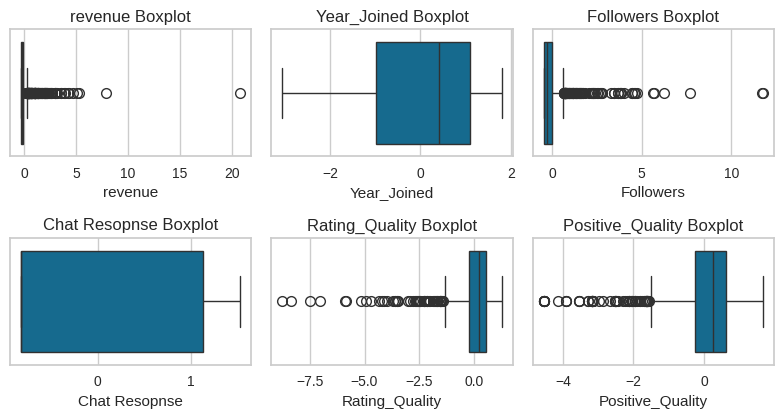

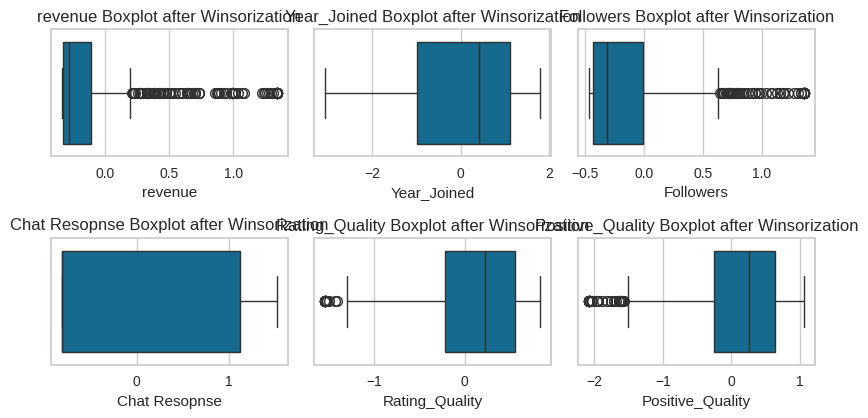

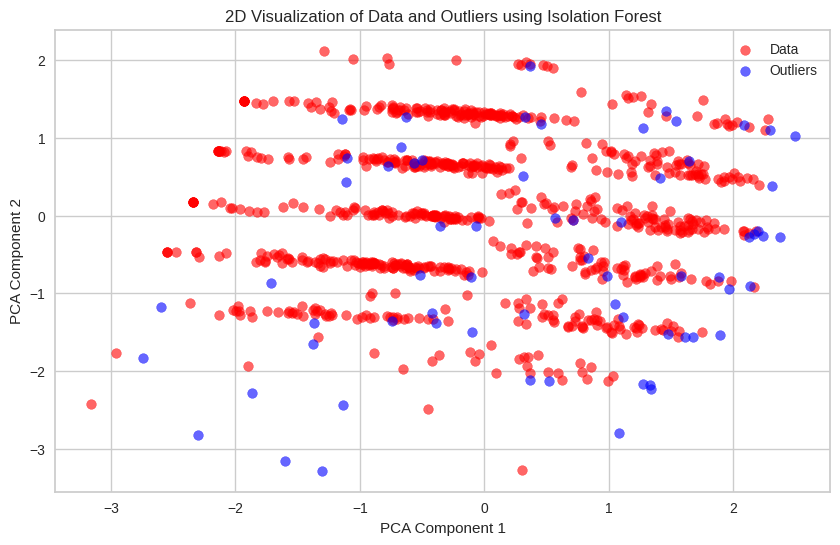

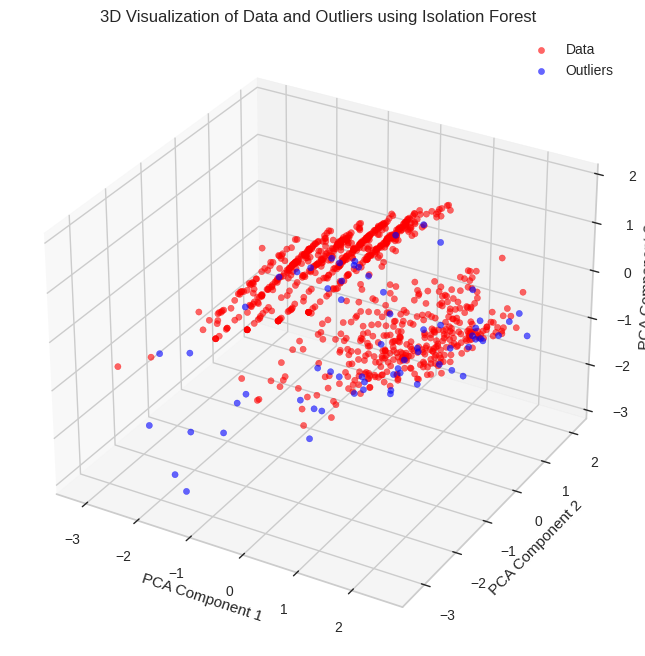

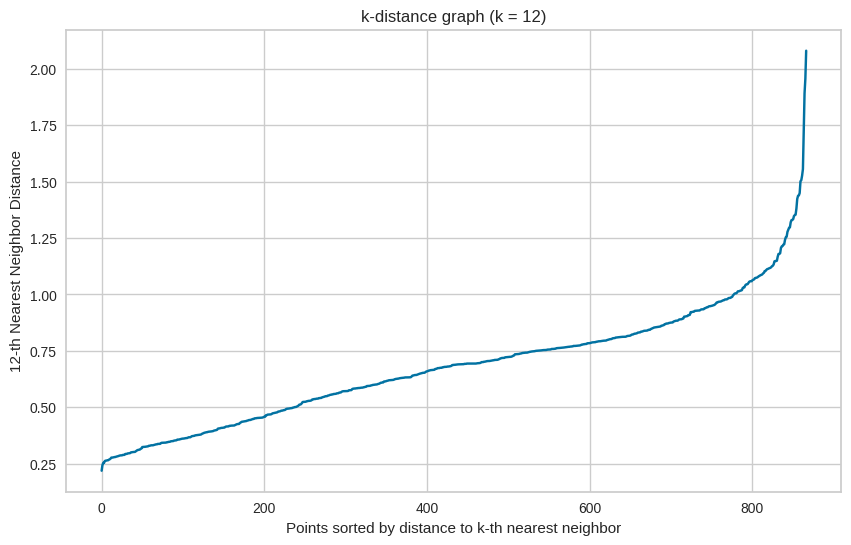

Clusters Information: {-1: 19, 0: 517, 1: 331}


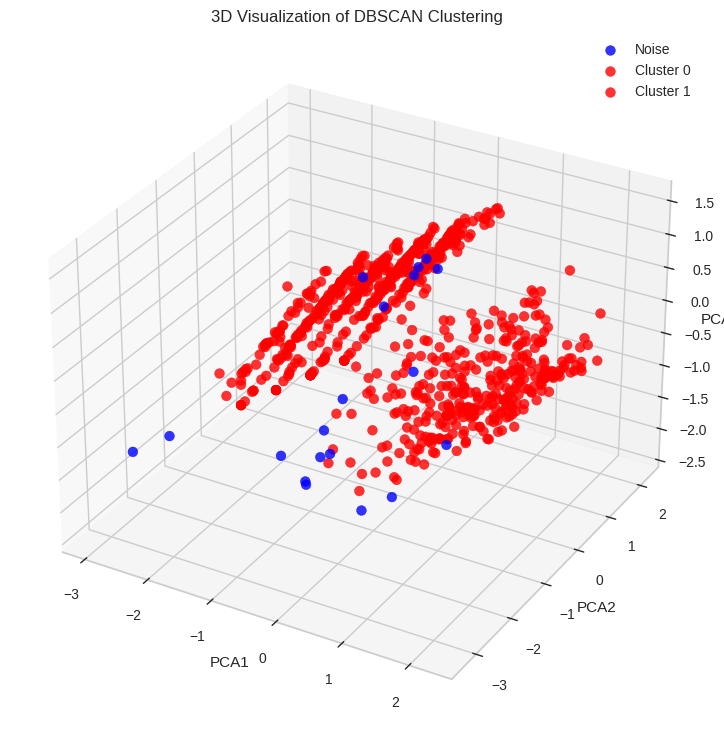

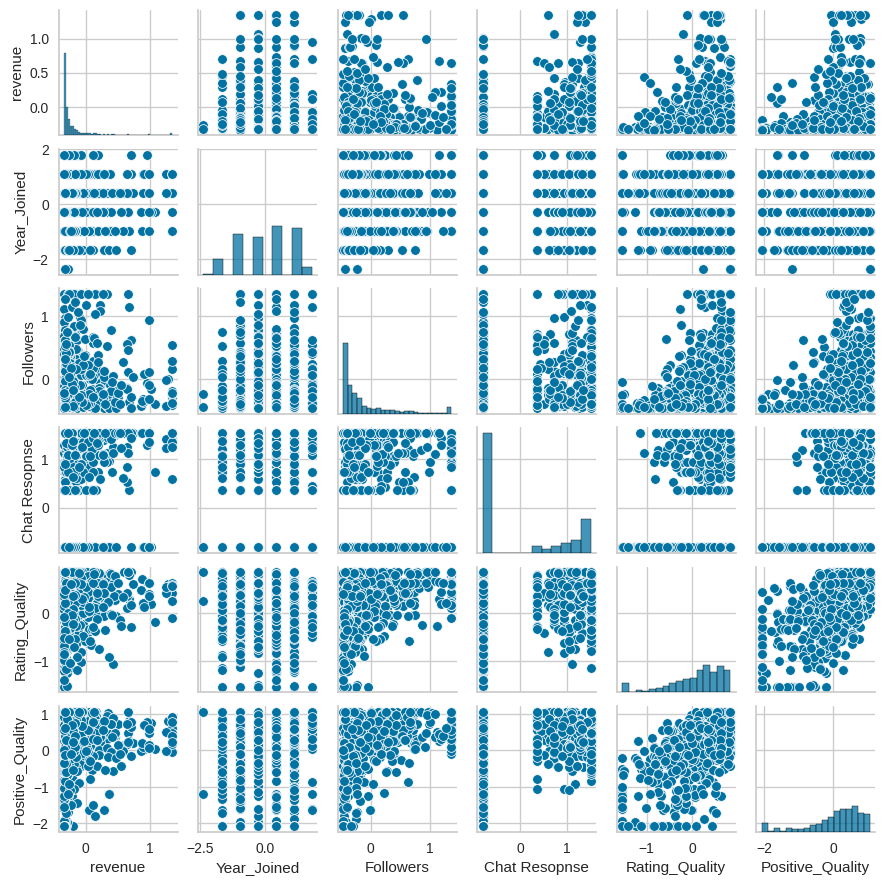

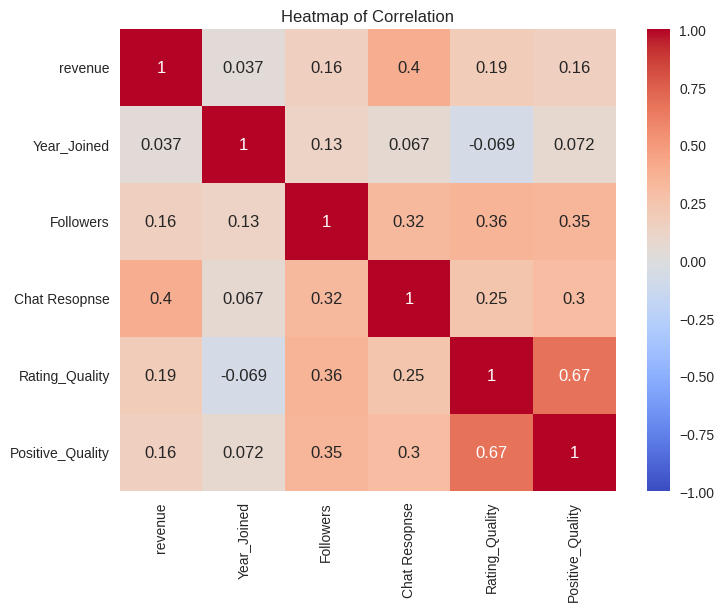

In [82]:
class DataAnalysisToolkit:
    def __init__(self, file_path):
        """Khởi tạo class với đường dẫn file dữ liệu"""
        self.file_path = file_path
        self.data = None
        self.confidence_z = norm.ppf(0.975)  # Giá trị z cho mức độ tin cậy 95%

    def load_data(self):
        """Đọc dữ liệu từ file Excel"""
        self.data = pd.read_excel(self.file_path)
        return self.data.head(2)

    def check_null_values(self):
        """Kiểm tra giá trị null trong dataframe"""
        null_values_summary = self.data.isnull().sum()
        print(null_values_summary)
        return null_values_summary

    def clean_data(self):
        """Thực hiện các bước làm sạch dữ liệu"""
        self.data['Chat Resopnse'] = self.data['Chat Resopnse'] / 100
        self.data = self.data.drop(columns=['Name_Shop'])
        self.data['Year_Joined'] = self.data['Year_Joined'].replace(0, 1)
        self.data = self.data[self.data['Counter_Rating'] != 0]
        return self.data

    def calculate_wilson_score_rating(self, shop_rating_col, counter_rating_col):
        """Tính điểm Wilson dựa trên đánh giá trung bình"""
        self.data['Rating_Quality'] = self.data.apply(
            lambda row: self._wilson_score_rating(row[shop_rating_col], row[counter_rating_col]), axis=1
        )

    def calculate_wilson_score_positive(self, positive_col, total_feedback_col):
        """Tính điểm Wilson dựa trên số phản hồi tích cực"""
        self.data['Positive_Quality'] = self.data.apply(
            lambda row: self._wilson_score_feedback(row[positive_col], row[total_feedback_col]), axis=1
        )

    def drop_unused_columns(self, columns_to_drop):
        """Xóa các cột không cần thiết"""
        self.data = self.data.drop(columns=columns_to_drop)

    def scale_and_visualize(self):
        """Chuẩn hóa dữ liệu và hiển thị boxplot"""
        scaler = StandardScaler()
        scaled_data_array = scaler.fit_transform(self.data)
        self.scaled_data = pd.DataFrame(scaled_data_array, columns=self.data.columns)

        plt.figure(figsize=(8, 6))
        for i, col in enumerate(self.scaled_data.columns):
            plt.subplot(3, 3, i + 1)
            sns.boxplot(x=self.scaled_data[col])
            plt.title(f'{col} Boxplot')
            plt.tight_layout()
        plt.show()

    def winsorize_columns(self, columns_to_winsorize, limits=[0.05, 0.05]):
        """Winsorize các cột được chỉ định"""
        for col in columns_to_winsorize:
            self.scaled_data[col] = winsorize(self.scaled_data[col], limits=limits)

        # Visualize boxplot after winsorization
        plt.figure(figsize=(8, 6))
        for i, col in enumerate(self.scaled_data.columns):
            plt.subplot(3, 3, i + 1)
            sns.boxplot(x=self.scaled_data[col])
            plt.title(f'{col} Boxplot after Winsorization')
            plt.tight_layout()
        plt.show()

    def _wilson_score_rating(self, average_rating, total_ratings):
        """Hàm nội bộ để tính điểm Wilson dựa trên đánh giá trung bình"""
        if total_ratings == 0:
            return 0
        p_hat = average_rating / 5
        denominator = 1 + self.confidence_z**2 / total_ratings
        center_adjusted_probability = p_hat + self.confidence_z**2 / (2 * total_ratings)
        adjusted_standard_deviation = self.confidence_z * np.sqrt(
            (p_hat * (1 - p_hat) + self.confidence_z**2 / (4 * total_ratings)) / total_ratings
        )
        wilson_lower_bound = (center_adjusted_probability - adjusted_standard_deviation) / denominator
        return wilson_lower_bound * 5

    def _wilson_score_feedback(self, positive, total_feedback):
        """Hàm nội bộ để tính điểm Wilson dựa trên phản hồi tích cực"""
        if total_feedback == 0:
            return 0
        p_hat = positive / total_feedback
        denominator = 1 + self.confidence_z**2 / total_feedback
        center_adjusted_probability = p_hat + self.confidence_z**2 / (2 * total_feedback)
        adjusted_standard_deviation = self.confidence_z * np.sqrt(
            (p_hat * (1 - p_hat) + self.confidence_z**2 / (4 * total_feedback)) / total_feedback
        )
        wilson_lower_bound = (center_adjusted_probability - adjusted_standard_deviation) / denominator
        return wilson_lower_bound

    def detect_outliers_with_isolation_forest(self, contamination=0.07):
        """Phát hiện outliers sử dụng Isolation Forest"""
        iso_forest = IsolationForest(contamination=contamination, random_state=42)
        self.outlier_pred = iso_forest.fit_predict(self.scaled_data)
        self.inliers_data = self.scaled_data[self.outlier_pred == 1]  # Các điểm không phải outlier
        return self.inliers_data

    def visualize_outliers_2d(self):
        """Trực quan hóa outliers trong không gian 2D sử dụng PCA"""
        # Giảm chiều dữ liệu xuống 2D bằng PCA
        pca_2d = PCA(n_components=2, random_state=42)
        df_pca_2d = pca_2d.fit_transform(self.scaled_data)

        # Phân loại dữ liệu và outliers
        df_pca_2d_data = df_pca_2d[self.outlier_pred == 1]  # Các điểm bình thường
        df_pca_2d_outliers = df_pca_2d[self.outlier_pred == -1]  # Các outliers

        # Trực quan hóa
        plt.figure(figsize=(10, 6))
        plt.scatter(df_pca_2d_data[:, 0], df_pca_2d_data[:, 1], color='red', label="Data", alpha=0.6)
        plt.scatter(df_pca_2d_outliers[:, 0], df_pca_2d_outliers[:, 1], color='blue', label="Outliers", alpha=0.6)
        plt.title("2D Visualization of Data and Outliers using Isolation Forest")
        plt.xlabel("PCA Component 1")
        plt.ylabel("PCA Component 2")
        plt.legend()
        plt.show()

    def visualize_outliers_3d(self):
        """Trực quan hóa outliers trong không gian 3D sử dụng PCA"""
        # Giảm chiều dữ liệu xuống 3D bằng PCA
        pca_3d = PCA(n_components=3, random_state=42)
        df_pca_3d = pca_3d.fit_transform(self.scaled_data)

        # Phân loại dữ liệu và outliers
        df_pca_3d_data = df_pca_3d[self.outlier_pred == 1]  # Các điểm bình thường
        df_pca_3d_outliers = df_pca_3d[self.outlier_pred == -1]  # Các outliers

        # Trực quan hóa
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(df_pca_3d_data[:, 0], df_pca_3d_data[:, 1], df_pca_3d_data[:, 2],
                   color='red', label="Data", alpha=0.6)
        ax.scatter(df_pca_3d_outliers[:, 0], df_pca_3d_outliers[:, 1], df_pca_3d_outliers[:, 2],
                   color='blue', label="Outliers", alpha=0.6)
        ax.set_title("3D Visualization of Data and Outliers using Isolation Forest")
        ax.set_xlabel("PCA Component 1")
        ax.set_ylabel("PCA Component 2")
        ax.set_zlabel("PCA Component 3")
        ax.legend()
        plt.show()


    def determine_eps_with_k_distance_graph(self, min_samples=12):
        """Xác định giá trị eps bằng cách sử dụng k-distance graph"""
        neighbors = NearestNeighbors(n_neighbors=min_samples)
        neighbors_fit = neighbors.fit(self.inliers_data)
        distances, indices = neighbors_fit.kneighbors(self.inliers_data)

        # Sắp xếp khoảng cách để tìm "góc gãy" trên đồ thị
        sorted_distances = np.sort(distances[:, min_samples - 1])

        # Vẽ k-distance graph
        plt.figure(figsize=(10, 6))
        plt.plot(sorted_distances)
        plt.title(f'k-distance graph (k = {min_samples})')
        plt.xlabel("Points sorted by distance to k-th nearest neighbor")
        plt.ylabel(f"{min_samples}-th Nearest Neighbor Distance")
        plt.grid(True)
        plt.show()

    def perform_dbscan_clustering(self, eps=1.05, min_samples=12):
        """Thực hiện DBSCAN clustering"""
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        self.dbscan_labels = dbscan.fit_predict(self.inliers_data)

        # Thống kê số lượng clusters và điểm noise
        unique_labels, counts = np.unique(self.dbscan_labels, return_counts=True)
        clusters_info = dict(zip(unique_labels, counts))
        print("Clusters Information:", clusters_info)

        return clusters_info

    def visualize_dbscan_clusters_3d(self):
        """Trực quan hóa các cụm DBSCAN trong không gian 3D"""
        pca_3d = PCA(n_components=3)
        inliers_pca_3d = pca_3d.fit_transform(self.inliers_data)

        fig = plt.figure(figsize=(12, 9))
        ax = fig.add_subplot(111, projection='3d')

        for label in np.unique(self.dbscan_labels):
            if label == -1:  # Noise
                color = [0, 0, 1, 1]  # Blue for noise
                label_name = "Noise"
            else:
                color = [1, 0, 0, 1]  # Red for clusters
                label_name = f"Cluster {label}"

            # Filter points belonging to the current cluster
            cluster_points = inliers_pca_3d[self.dbscan_labels == label]

            ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2],
                       c=[color], label=label_name, s=50, alpha=0.8)

        # Customize the plot
        ax.set_title("3D Visualization of DBSCAN Clustering")
        ax.set_xlabel("PCA1")
        ax.set_ylabel("PCA2")
        ax.set_zlabel("PCA3")
        ax.legend(loc="best")
        plt.show()

    def analyze_non_noise_points(self):
        """Phân tích các điểm không phải noise"""
        non_noise_mask = self.dbscan_labels != -1
        X_non_noise = self.inliers_data[non_noise_mask]

        # Pairplot for non-noise data
        sns.pairplot(X_non_noise, height=1.5)
        plt.show()

        # Heatmap of correlation matrix
        correlation_matrix = X_non_noise.corr()
        plt.figure(figsize=(8, 6))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
        plt.title("Heatmap of Correlation")
        plt.show()
# Sử dụng class
if __name__ == "__main__":
    toolkit = DataAnalysisToolkit('/content/drive/My Drive/Colab Notebooks/NCKH (Ph. Danh Hường)/Data thô/data_cleaned.xlsx')
    print(toolkit.load_data())
    toolkit.check_null_values()
    toolkit.clean_data()
    toolkit.calculate_wilson_score_rating('Shop_Rating', 'Counter_Rating')
    toolkit.calculate_wilson_score_positive('positive', 'total_feedback')
    toolkit.drop_unused_columns(['positive', 'negative', 'total_feedback', 'Shop_Rating', 'Counter_Rating'])
    toolkit.scale_and_visualize()

    toolkit.winsorize_columns(['revenue', 'Followers', 'Rating_Quality', 'Positive_Quality'])

    # Phát hiện và trực quan hóa outliers
    toolkit.detect_outliers_with_isolation_forest(contamination=0.07)
    toolkit.visualize_outliers_2d()
    toolkit.visualize_outliers_3d()

    # Xác định eps cho DBSCAN
    toolkit.determine_eps_with_k_distance_graph(min_samples=12)
    # Thực hiện DBSCAN clustering
    clusters_info = toolkit.perform_dbscan_clustering(eps=1.05, min_samples=12)
    # Trực quan hóa các cụm trong không gian 3D
    toolkit.visualize_dbscan_clusters_3d()
    # Phân tích các điểm không phải noise
    toolkit.analyze_non_noise_points()
    # Get X_non_noise from the toolkit object
    X_non_noise = toolkit.inliers_data[toolkit.dbscan_labels != -1]

# ***`Chọn số cụm tối ưu`***

In [83]:
class OptimalClusterSelector:
    def __init__(self, data):
        """
        Khởi tạo class với dữ liệu đầu vào.
        :param data: Dữ liệu để thực hiện phân cụm (đã được chuẩn hóa và xử lý).
        """
        self.data = data
        self.kmeans_scores = []
        self.agglomerative_scores = []
        self.gmm_scores = []

    def calculate_silhouette_scores(self, max_clusters=10):
        """
        Tính toán Silhouette Scores cho các thuật toán phân cụm.
        :param max_clusters: Số cụm tối đa cần thử nghiệm.
        """
        cluster_range = range(3, max_clusters + 1)

        # K-Means
        for k in cluster_range:
            kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
            kmeans_labels = kmeans.fit_predict(self.data)
            self.kmeans_scores.append(silhouette_score(self.data, kmeans_labels))

        # Agglomerative Clustering
        for k in cluster_range:
            agg = AgglomerativeClustering(n_clusters=k, linkage='ward')
            agg_labels = agg.fit_predict(self.data)
            self.agglomerative_scores.append(silhouette_score(self.data, agg_labels))

        # Gaussian Mixture Model (GMM)
        for k in cluster_range:
            gmm = GaussianMixture(n_components=k, covariance_type='spherical', random_state=42)
            gmm_labels = gmm.fit_predict(self.data)
            self.gmm_scores.append(silhouette_score(self.data, gmm_labels))

        return cluster_range

    def visualize_silhouette_scores(self, cluster_range):
        """
        Vẽ biểu đồ so sánh Silhouette Scores của các thuật toán phân cụm.
        :param cluster_range: Dải số cụm đã thử nghiệm.
        """
        plt.figure(figsize=(10, 6))
        plt.plot(cluster_range, self.kmeans_scores, marker='o', linestyle='-', linewidth=2, color='#FF6F61', label='K-Means')
        plt.plot(cluster_range, self.agglomerative_scores, marker='o', linestyle='-', linewidth=2, color='#6B5B95', label='Agglomerative')
        plt.plot(cluster_range, self.gmm_scores, marker='o', linestyle='-', linewidth=2, color='#2A9D8F', label='GMM')

        # Định dạng biểu đồ
        plt.title("Silhouette Scores for Clustering Algorithms", fontsize=14, fontweight='bold')
        plt.xlabel("Number of Clusters (K)", fontsize=12)
        plt.ylabel("Silhouette Score", fontsize=12)
        plt.xticks(cluster_range)
        plt.legend()
        plt.grid(False)
        plt.tight_layout()
        plt.show()

    def print_optimal_clusters(self, cluster_range):
        """
        In ra số cụm tối ưu cho từng thuật toán dựa trên Silhouette Scores.
        :param cluster_range: Dải số cụm đã thử nghiệm.
        """
        optimal_k_kmeans = cluster_range[np.argmax(self.kmeans_scores)]
        optimal_k_agg = cluster_range[np.argmax(self.agglomerative_scores)]
        optimal_k_gmm = cluster_range[np.argmax(self.gmm_scores)]

        print(f"Optimal K for K-Means: {optimal_k_kmeans}")
        print(f"Optimal K for Agglomerative Clustering: {optimal_k_agg}")
        print(f"Optimal K for Gaussian Mixture Model (GMM): {optimal_k_gmm}")

    def find_optimal_clusters(self, max_clusters=10):
        """
        Chạy toàn bộ quy trình tìm kiếm số cụm tối ưu.
        :param max_clusters: Số cụm tối đa cần thử nghiệm.
        """
        cluster_range = self.calculate_silhouette_scores(max_clusters=max_clusters)
        self.visualize_silhouette_scores(cluster_range)
        self.print_optimal_clusters(cluster_range)

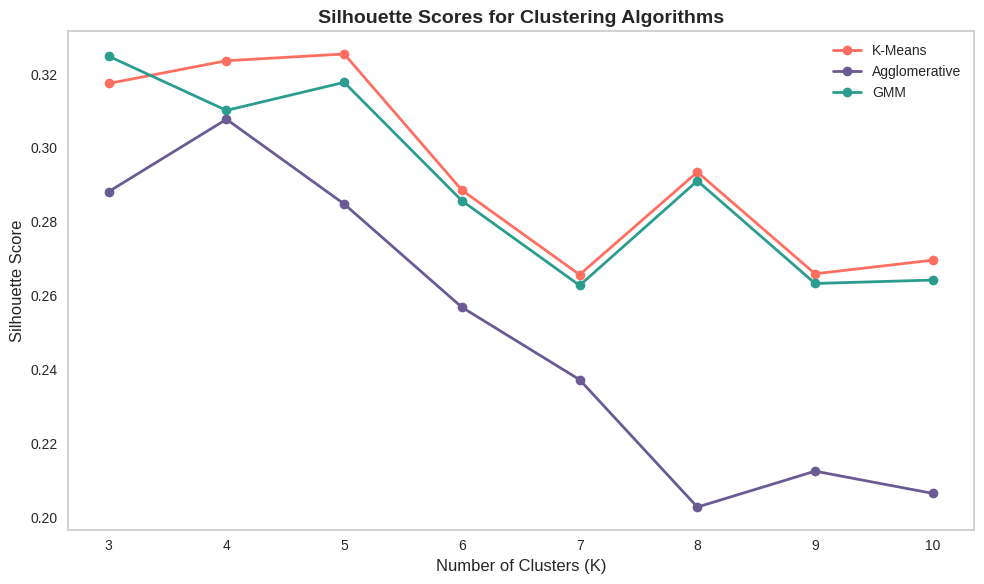

Optimal K for K-Means: 5
Optimal K for Agglomerative Clustering: 4
Optimal K for Gaussian Mixture Model (GMM): 3


In [84]:
if __name__ == "__main__":

    # Sử dụng dữ liệu không chứa outliers từ class trước đó
    selector = OptimalClusterSelector(X_non_noise)
    # Tìm và hiển thị số cụm tối ưu
    selector.find_optimal_clusters(max_clusters=10)

# ***`Clustering`***

In [85]:
class ClusterAnalyzer:
    def __init__(self, data):
        """
        Khởi tạo class với dữ liệu.
        :param data: Dữ liệu để phân cụm (đã chuẩn hóa và loại bỏ noise).
        """
        self.data = data

    def perform_clustering(self, method, n_clusters):
        """
        Thực hiện phân cụm và trả về nhãn cùng với các chỉ số đánh giá.
        :param method: Thuật toán phân cụm ('kmeans', 'agglomerative', 'gmm').
        :param n_clusters: Số cụm cần phân chia.
        :return: Nhãn phân cụm và các chỉ số đánh giá (Silhouette, DBI, CHI).
        """
        if method == 'kmeans':
            model = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
        elif method == 'agglomerative':
            model = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
        elif method == 'gmm':
            model = GaussianMixture(n_components=n_clusters, covariance_type='spherical', random_state=42)
        else:
            raise ValueError("Invalid clustering method. Choose 'kmeans', 'agglomerative', or 'gmm'.")

        labels = model.fit_predict(self.data)
        silhouette = silhouette_score(self.data, labels)
        dbi = davies_bouldin_score(self.data, labels)
        chi = calinski_harabasz_score(self.data, labels)

        print(f"{method.upper()} Clustering:")
        print(f"Silhouette Score: {silhouette}")
        print(f"Davies-Bouldin Index (DBI): {dbi}")
        print(f"Calinski-Harabasz Index (CHI): {chi}\n")

        return labels, silhouette, dbi, chi

    def visualize_clusters_2d(self, labels, title):
        """
        Trực quan hóa cụm trong không gian 2D sử dụng PCA.
        :param labels: Nhãn phân cụm.
        :param title: Tiêu đề của biểu đồ.
        """
        pca = PCA(n_components=2)
        data_pca = pca.fit_transform(self.data)

        plt.figure(figsize=(8, 6))
        plt.scatter(data_pca[:, 0], data_pca[:, 1], c=labels, cmap='viridis', edgecolor='k', s=50)
        plt.title(f'2D Visualization of Clusters ({title})')
        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')
        plt.colorbar(label='Cluster')
        plt.show()

    def visualize_clusters_3d(self, labels, title):
        """
        Trực quan hóa cụm trong không gian 3D sử dụng PCA.
        :param labels: Nhãn phân cụm.
        :param title: Tiêu đề của biểu đồ.
        """
        pca = PCA(n_components=3)
        data_pca = pca.fit_transform(self.data)

        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(data_pca[:, 0], data_pca[:, 1], data_pca[:, 2], c=labels, cmap='viridis', edgecolor='k', s=50)

        ax.set_title(f'3D Visualization of Clusters ({title})')
        ax.set_xlabel('PCA Component 1')
        ax.set_ylabel('PCA Component 2')
        ax.set_zlabel('PCA Component 3')

        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label('Cluster')

        plt.show()

KMEANS Clustering:
Silhouette Score: 0.3254378596523363
Davies-Bouldin Index (DBI): 1.08809952730434
Calinski-Harabasz Index (CHI): 415.9347128303202



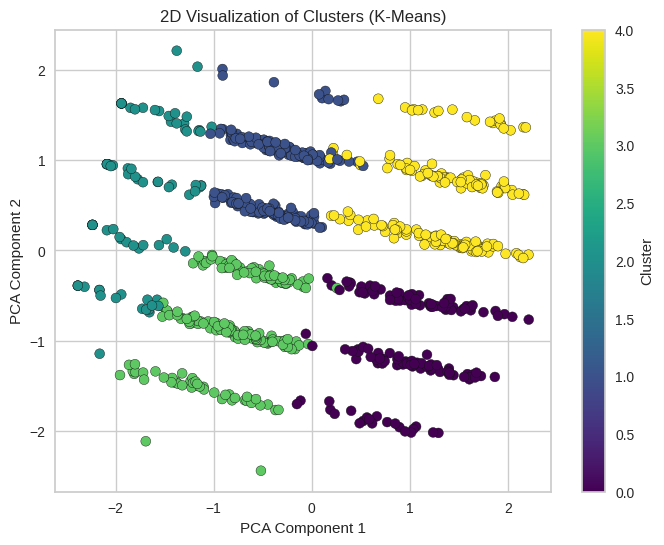

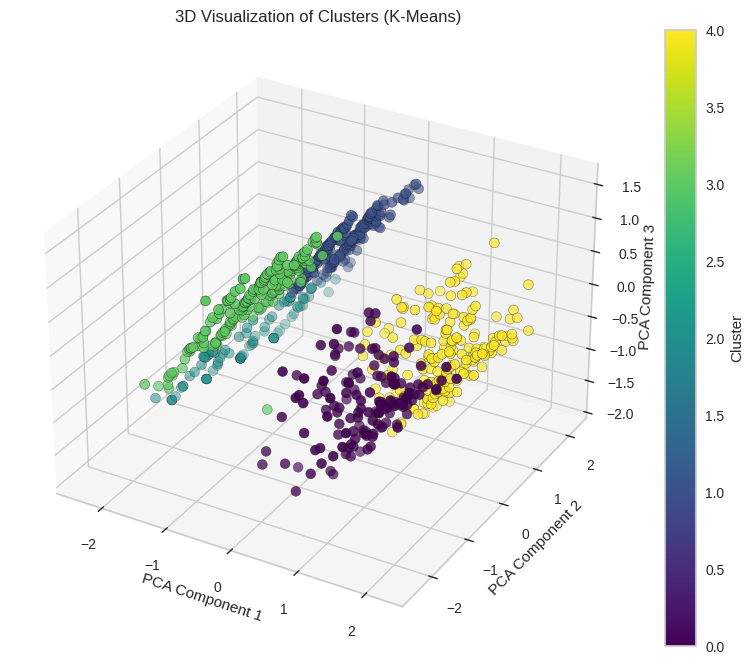

AGGLOMERATIVE Clustering:
Silhouette Score: 0.30776427937107986
Davies-Bouldin Index (DBI): 1.0362186155527848
Calinski-Harabasz Index (CHI): 361.2399207765577



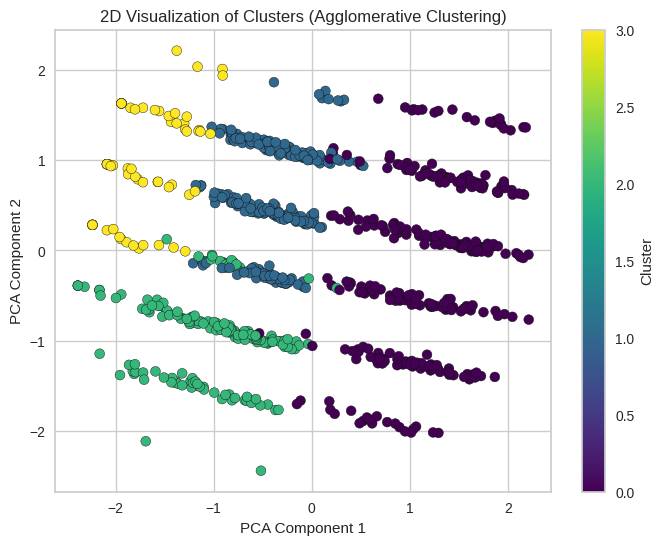

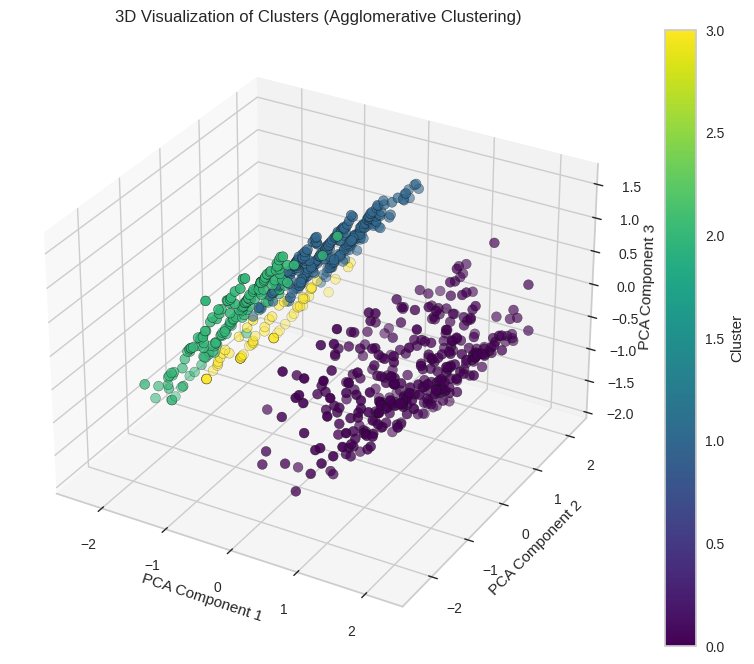

GMM Clustering:
Silhouette Score: 0.3248303337361954
Davies-Bouldin Index (DBI): 1.2493580925899959
Calinski-Harabasz Index (CHI): 378.2464882153665



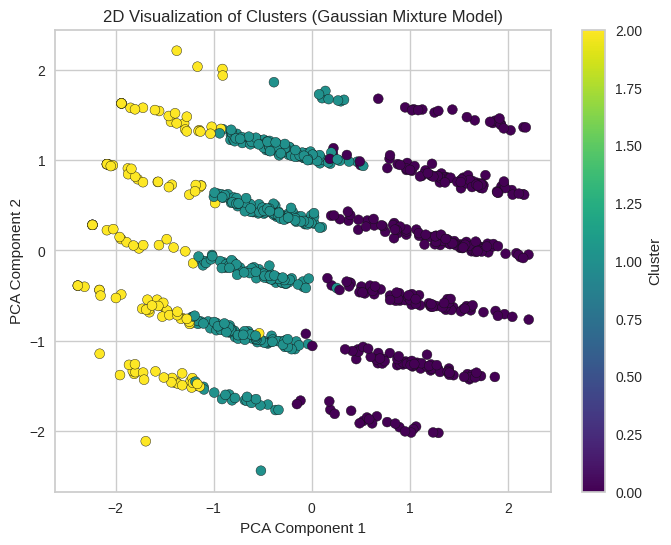

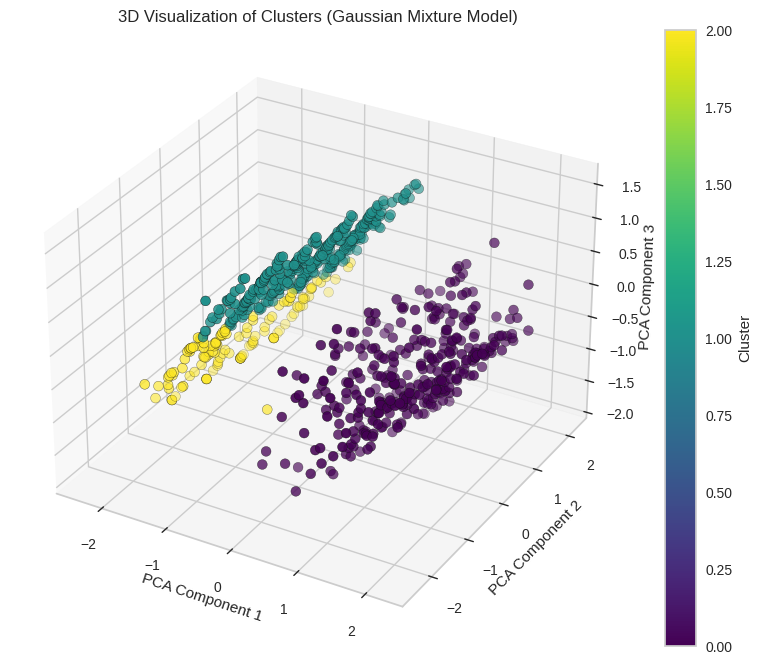

In [86]:
# Sử dụng class
if __name__ == "__main__":
    # Dữ liệu X_non_noise từ class trước
    n_clusters_kmeans = 5
    n_clusters_agglomerative = 4
    n_clusters_gmm = 3

    cluster_analyzer = ClusterAnalyzer(X_non_noise)

    # K-Means
    kmeans_labels, _, _, _ = cluster_analyzer.perform_clustering('kmeans', n_clusters_kmeans)
    cluster_analyzer.visualize_clusters_2d(kmeans_labels, 'K-Means')
    cluster_analyzer.visualize_clusters_3d(kmeans_labels, 'K-Means')

    # Agglomerative Clustering
    agg_labels, _, _, _ = cluster_analyzer.perform_clustering('agglomerative', n_clusters_agglomerative)
    cluster_analyzer.visualize_clusters_2d(agg_labels, 'Agglomerative Clustering')
    cluster_analyzer.visualize_clusters_3d(agg_labels, 'Agglomerative Clustering')

    # Gaussian Mixture Model
    gmm_labels, _, _, _ = cluster_analyzer.perform_clustering('gmm', n_clusters_gmm)
    cluster_analyzer.visualize_clusters_2d(gmm_labels, 'Gaussian Mixture Model')
    cluster_analyzer.visualize_clusters_3d(gmm_labels, 'Gaussian Mixture Model')

# ***`MAXIMAL FREQUENT ITEMSET`***

# ***`K-Bin Discritizer`***

In [ ]:
def apply_kmeans(column_data, n_clusters=3):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    column_data = column_data.values.reshape(-1, 1)  # Reshape for single feature
    return kmeans.fit_predict(column_data)

# Apply K-Means to each column
clustered_columns = {}
for column in X_non_noise.columns:
    clustered_columns[column] = apply_kmeans(X_non_noise[column])

# Add the cluster labels to the DataFrame
for column, labels in clustered_columns.items():
    X_non_noise[f'{column}_class'] = labels


In [ ]:
X_non_noise.head(2)

revenue  Year_Joined  Followers  Chat Resopnse  Rating_quality  \
0 -0.326840    -0.279443  -0.143533      -0.819518        0.517466   
1 -0.143226    -0.972848   0.031235      -0.819518        0.539159   

   Positive_quality  revenue_class  Year_Joined_class  Followers_class  \
0          0.731572              1                  0                0   
1          0.189270              1                  0                2   

   Chat Resopnse_class  Rating_quality_class  Positive_quality_class  
0                    1                     0                       0  
1                    1                     0                       1

In [ ]:
min_max_df = X_non_noise.groupby('Positive_quality_class')['Positive_quality'].agg(['min', 'max'])
print(min_max_df)

                             min       max
Positive_quality_class                    
0                       0.229047  1.056228
1                      -0.890794  0.227831
2                      -2.078343 -0.912847


In [ ]:
# Revenue
X_non_noise['revenue_class'] = X_non_noise['revenue_class'].replace(0, "High")
X_non_noise['revenue_class'] = X_non_noise['revenue_class'].replace(1, "Low")
X_non_noise['revenue_class'] = X_non_noise['revenue_class'].replace(2, "Medium")
#Year_Joined
X_non_noise['Year_Joined_class'] = X_non_noise['Year_Joined_class'].replace(0, "Low")
X_non_noise['Year_Joined_class'] = X_non_noise['Year_Joined_class'].replace(1, "High")
X_non_noise['Year_Joined_class'] = X_non_noise['Year_Joined_class'].replace(2, "Medium")
# Followers
X_non_noise['Followers_class'] = X_non_noise['Followers_class'].replace(0, "Low")
X_non_noise['Followers_class'] = X_non_noise['Followers_class'].replace(1, "High")
X_non_noise['Followers_class'] = X_non_noise['Followers_class'].replace(2, "Medim")
# Chat Resopnse
X_non_noise['Chat Resopnse_class'] = X_non_noise['Chat Resopnse_class'].replace(0, "Medium")
X_non_noise['Chat Resopnse_class'] = X_non_noise['Chat Resopnse_class'].replace(1, "Low")
X_non_noise['Chat Resopnse_class'] = X_non_noise['Chat Resopnse_class'].replace(2, "High")
#Rating Quality
X_non_noise['Rating_quality_class'] = X_non_noise['Rating_quality_class'].replace(0, "High")
X_non_noise['Rating_quality_class'] = X_non_noise['Rating_quality_class'].replace(1, "Medium")
X_non_noise['Rating_quality_class'] = X_non_noise['Rating_quality_class'].replace(2, "Low")
#positive
X_non_noise['Positive_quality_class'] = X_non_noise['Positive_quality_class'].replace(0, "High")
X_non_noise['Positive_quality_class'] = X_non_noise['Positive_quality_class'].replace(1, "Medium")
X_non_noise['Positive_quality_class'] = X_non_noise['Positive_quality_class'].replace(2, "Low")

In [ ]:
X_non_noise.to_excel('/content/drive/My Drive/Colab Notebooks/NCKH (Ph. Danh Hường)/Data thô/data_discretization.xlsx')

# ***`FP-Max`***

In [ ]:
X_non_noise = pd.read_excel('/content/drive/My Drive/Colab Notebooks/NCKH (Ph. Danh Hường)/Data thô/data_discretization.xlsx')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
X_non_noise_cate = X_non_noise.iloc[:, 7:]
X_non_noise_dummies = pd.get_dummies(X_non_noise_cate)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
item_count = {}
for col in X_non_noise_dummies.columns:
    item_count[col] = X_non_noise_dummies[col].sum()
item_freq_df = pd.DataFrame(data=list(item_count.values()), index=list(item_count.keys()), columns=['frequency']).sort_values(by='frequency', ascending=False)
item_freq_df.shape, item_freq_df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


((18, 1),
                                frequency
 revenue_class_Low                    693
 Followers_class_Low                  625
 Chat Resopnse_class_Low              514
 Rating_quality_class_High            480
 Year_Joined_class_High               432
 Positive_quality_class_High          426
 Year_Joined_class_Medium             330
 Positive_quality_class_Medium        313
 Rating_quality_class_Medium          274
 Chat Resopnse_class_High             211
 Followers_class_Medim                145
 Chat Resopnse_class_Medium           106
 revenue_class_Medium                 106
 Positive_quality_class_Low            92
 Rating_quality_class_Low              77
 Year_Joined_class_Low                 69
 Followers_class_High                  61
 revenue_class_High                    32)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


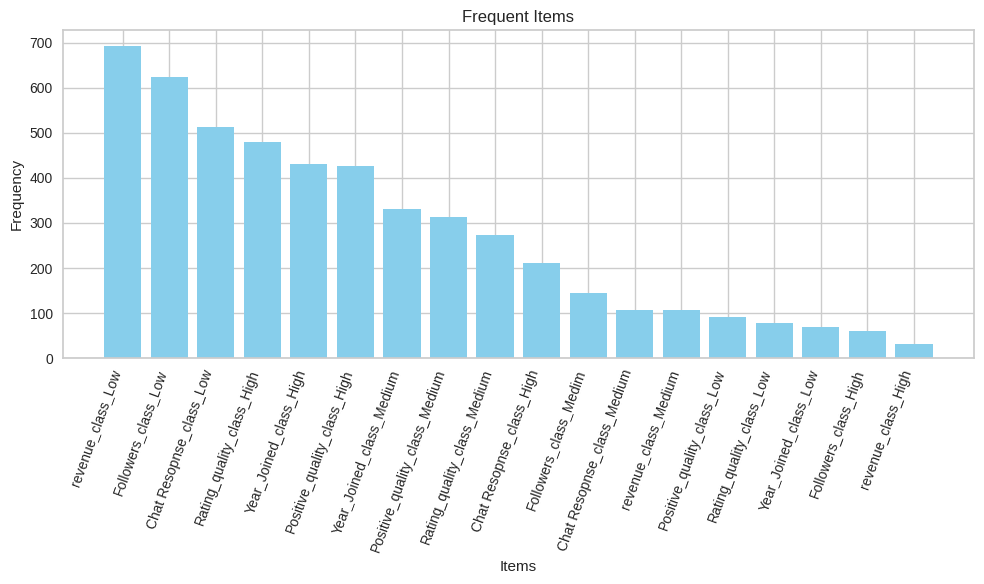

In [ ]:
# Calculate the sum of each column (representing the frequency of each item)
column_sums = X_non_noise_dummies.sum()
# Sort the columns by sum in descending order
sorted_columns = column_sums.sort_values(ascending=False)

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(sorted_columns.index, sorted_columns.values, color='skyblue')
plt.xlabel('Items')
plt.ylabel('Frequency')
plt.title('Frequent Items')
plt.xticks(rotation=70, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [ ]:
from mlxtend.frequent_patterns import fpmax, fpgrowth, apriori

# Tìm các tập mục phổ biến tối đại
frequent_itemsets = apriori(X_non_noise_dummies, min_support=0.2, use_colnames=True)
frequent_itemsets = pd.DataFrame(frequent_itemsets)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
frequent_itemsets = frequent_itemsets.sort_values(by='support', ascending=False)
frequent_itemsets = pd.DataFrame(frequent_itemsets)
print(frequent_itemsets)

     support                                           itemsets
0   0.833935                                (revenue_class_Low)
3   0.752106                              (Followers_class_Low)
12  0.658243           (revenue_class_Low, Followers_class_Low)
5   0.618532                          (Chat Resopnse_class_Low)
13  0.580024       (revenue_class_Low, Chat Resopnse_class_Low)
..       ...                                                ...
52  0.208183  (Year_Joined_class_High, Positive_quality_clas...
55  0.206980  (Followers_class_Low, Chat Resopnse_class_Low,...
47  0.205776  (revenue_class_Low, Chat Resopnse_class_Low, R...
56  0.204573  (Followers_class_Low, Chat Resopnse_class_Low,...
62  0.202166  (revenue_class_Low, Rating_quality_class_High,...

[63 rows x 2 columns]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
frequent_itemsets.to_excel('/content/drive/My Drive/Colab Notebooks/NCKH (Ph. Danh Hường)/Data thô/data_fpmax.xlsx')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# ***`Create New Binary Features`***

In [ ]:
X_non_noise.head(2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



revenue  Year_Joined  Followers  Chat Resopnse  Rating_quality  \
0 -0.326840    -0.279443  -0.143533      -0.819518        0.517466   
1 -0.143226    -0.972848   0.031235      -0.819518        0.539159   

   Positive_quality revenue_class Year_Joined_class Followers_class  \
0          0.731572           Low            Medium             Low   
1          0.189270           Low            Medium           Medim   

  Chat Resopnse_class Rating_quality_class Positive_quality_class  
0                 Low                 High                   High  
1                 Low                 High                 Medium

In [ ]:
# 1. 'Positive_quality_class_High', 'revenue_class_Low', 'Rating_quality_class_High'
X_non_noise['Positive_High_revenue_Low_Rating_High'] = (
    (X_non_noise['Positive_quality_class'] == 'High') &
    (X_non_noise['revenue_class'] == 'Low') &
    (X_non_noise['Rating_quality_class'] == 'High')
).astype(int)

# 2. 'Followers_class_Low', 'revenue_class_Low', 'Positive_quality_class_High'
X_non_noise['Followers_Low_revenue_Low_Positive_High'] = (
    (X_non_noise['Followers_class'] == 'Low') &
    (X_non_noise['revenue_class'] == 'Low') &
    (X_non_noise['Positive_quality_class'] == 'High')
).astype(int)

# 3. 'Chat Resopnse_class_High'
X_non_noise['Chat_Response_High'] = (
    (X_non_noise['Chat Resopnse_class'] == 'High')
).astype(int)

# 4. 'Chat Resopnse_class_Low', 'revenue_class_Low', 'Positive_quality_class_High'
X_non_noise['Chat_Low_revenue_Low_Positive_High'] = (
    (X_non_noise['Chat Resopnse_class'] == 'Low') &
    (X_non_noise['revenue_class'] == 'Low') &
    (X_non_noise['Positive_quality_class'] == 'High')
).astype(int)

# 5. 'Chat Resopnse_class_Low', 'Year_Joined_class_Low', 'Followers_class_Low', 'revenue_class_Low'
X_non_noise['Chat_Low_Year_Low_Followers_Low_revenue_Low'] = (
    (X_non_noise['Chat Resopnse_class'] == 'Low') &
    (X_non_noise['Year_Joined_class'] == 'Low') &
    (X_non_noise['Followers_class'] == 'Low') &
    (X_non_noise['revenue_class'] == 'Low')
).astype(int)

# 6. 'Year_Joined_class_Low', 'Positive_quality_class_High'
X_non_noise['Year_Low_Positive_High'] = (
    (X_non_noise['Year_Joined_class'] == 'Low') &
    (X_non_noise['Positive_quality_class'] == 'High')
).astype(int)

# 7. 'Year_Joined_class_High', 'revenue_class_Low'
X_non_noise['Year_High_revenue_Low'] = (
    (X_non_noise['Year_Joined_class'] == 'High') &
    (X_non_noise['revenue_class'] == 'Low')
).astype(int)

# 8. 'Year_Joined_class_Low', 'revenue_class_Low', 'Rating_quality_class_High'
X_non_noise['Year_Low_revenue_Low_Rating_High'] = (
    (X_non_noise['Year_Joined_class'] == 'Low') &
    (X_non_noise['revenue_class'] == 'Low') &
    (X_non_noise['Rating_quality_class'] == 'High')
).astype(int)

# 9. 'Followers_class_Low', 'Positive_quality_class_High', 'Rating_quality_class_High'
X_non_noise['Followers_Low_Positive_High_Rating_High'] = (
    (X_non_noise['Followers_class'] == 'Low') &
    (X_non_noise['Positive_quality_class'] == 'High') &
    (X_non_noise['Rating_quality_class'] == 'High')
).astype(int)

# 10. 'Chat Resopnse_class_Low', 'Followers_class_Low', 'revenue_class_Low', 'Rating_quality_class_High'
X_non_noise['Chat_Low_Followers_Low_revenue_Low_Rating_High'] = (
    (X_non_noise['Chat Resopnse_class'] == 'Low') &
    (X_non_noise['Followers_class'] == 'Low') &
    (X_non_noise['revenue_class'] == 'Low') &
    (X_non_noise['Rating_quality_class'] == 'High')
).astype(int)

# 11. 'Chat Resopnse_class_Low', 'Followers_class_Low', 'Positive_quality_class_High'
X_non_noise['Chat_Low_Followers_Low_Positive_High'] = (
    (X_non_noise['Chat Resopnse_class'] == 'Low') &
    (X_non_noise['Followers_class'] == 'Low') &
    (X_non_noise['Positive_quality_class'] == 'High')
).astype(int)

# 12. 'Chat Resopnse_class_Low', 'Followers_class_Low', 'Positive_quality_class_Medium', 'revenue_class_Low'
X_non_noise['Chat_Low_Followers_Low_Positive_Medium_revenue_Low'] = (
    (X_non_noise['Chat Resopnse_class'] == 'Low') &
    (X_non_noise['Followers_class'] == 'Low') &
    (X_non_noise['Positive_quality_class'] == 'Medium') &
    (X_non_noise['revenue_class'] == 'Low')
).astype(int)

# 13. 'Year_Joined_class_Medium', 'revenue_class_Low'
X_non_noise['Year_Medium_revenue_Low'] = (
    (X_non_noise['Year_Joined_class'] == 'Medium') &
    (X_non_noise['revenue_class'] == 'Low')
).astype(int)

# 14. 'Chat Resopnse_class_Low', 'Rating_quality_class_Medium', 'Followers_class_Low', 'revenue_class_Low'
X_non_noise['Chat_Low_Rating_Medium_Followers_Low_revenue_Low'] = (
    (X_non_noise['Chat Resopnse_class'] == 'Low') &
    (X_non_noise['Rating_quality_class'] == 'Medium') &
    (X_non_noise['Followers_class'] == 'Low') &
    (X_non_noise['revenue_class'] == 'Low')
).astype(int)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
X_non_noise_final = X_non_noise.drop(columns = ['revenue_class', 'Year_Joined_class', 'Followers_class', 'Chat Resopnse_class', 'Rating_quality_class', 'Positive_quality_class'])
X_non_noise_final.head(2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


revenue  Year_Joined  Followers  Chat Resopnse  Rating_quality  \
0 -0.326840    -0.279443  -0.143533      -0.819518        0.517466   
1 -0.143226    -0.972848   0.031235      -0.819518        0.539159   

   Positive_quality  Positive_High_revenue_Low_Rating_High  \
0          0.731572                                      1   
1          0.189270                                      0   

   Followers_Low_revenue_Low_Positive_High  Chat_Response_High  \
0                                        1                   0   
1                                        0                   0   

   Chat_Low_revenue_Low_Positive_High  \
0                                   1   
1                                   0   

   Chat_Low_Year_Low_Followers_Low_revenue_Low  Year_Low_Positive_High  \
0                                            1                       1   
1                                            0                       0   

   Year_High_revenue_Low  Year_Low_revenue_Low_Rating_High  \
0                      0                                 1   
1                      0                                 1   

   Followers_Low_Positive_High_Rating_High  \
0                                        1   
1                                        0   

   Chat_Low_Followers_Low_revenue_Low_Rating_High  \
0                                               1   
1                                               0   

   Chat_Low_Followers_Low_Positive_High  \
0                                     1   
1                                     0   

   Chat_Low_Followers_Low_Positive_Medium_revenue_Low  \
0                                                  0    
1                                                  0    

   Year_Medium_revenue_Low  Chat_Low_Rating_Medium_Followers_Low_revenue_Low  
0                        0                                                 0  
1                        0                                                 0

In [ ]:
X_non_noise_final.to_excel('/content/drive/My Drive/Colab Notebooks/NCKH (Ph. Danh Hường)/Data thô/data_final.xlsx')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# ***`CLUSTERING AFTER USING FREQUENT ITEMSET`***

# ***`Forward Selection for K-Means`***

In [ ]:
X_non_noise_final =pd.read_excel('/content/drive/My Drive/Colab Notebooks/NCKH (Ph. Danh Hường)/Data thô/data_final.xlsx')
X_non_noise_final = X_non_noise_final.drop(columns = ['Unnamed: 0'])
X_non_noise_final_continuous = X_non_noise_final.iloc[:, :6]
X_non_noise_final_categorical = X_non_noise_final.iloc[:, 6:]

# ***`K-Prototypes through Forward Selection`***

Silhouette Score (dữ liệu hỗn hợp): 0.44576058
Davies-Bouldin Index (dữ liệu hỗn hợp): 1.1356932818335124
Calinski-Harabasz Index (CHI): 585.6486058638367


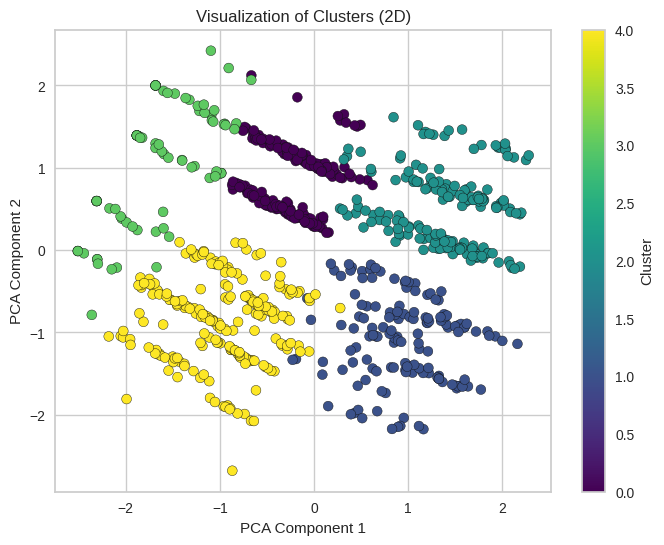

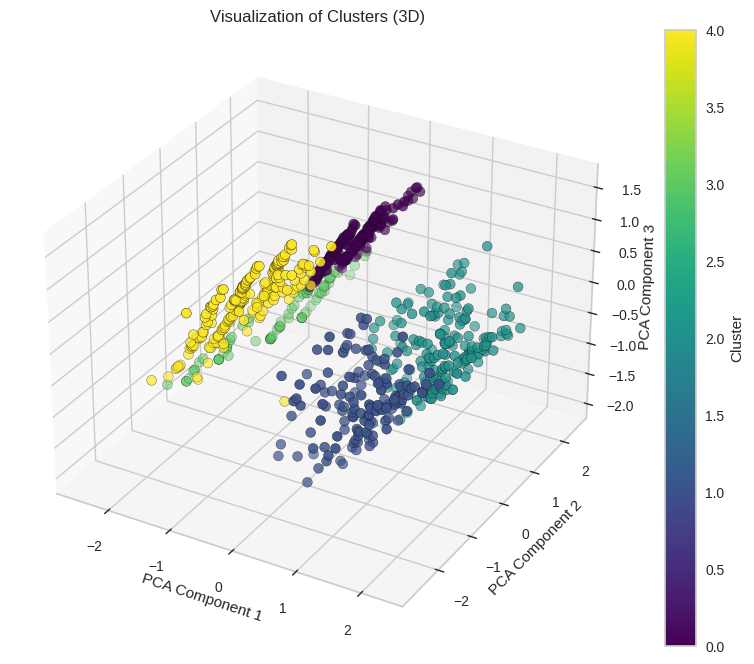

In [88]:
import pandas as pd
from gower import gower_matrix
from kmodes.kprototypes import KPrototypes
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

class FeatureSelectorClusterEvaluator:
    def __init__(self, file_path):
        """
        Khởi tạo class với đường dẫn đến file dữ liệu.
        """
        self.file_path = file_path
        self.data = None
        self.continuous_data = None
        self.categorical_data = None
        self.selected_features = None
        self.best_silhouette_score = -1
        self.kmeansclusters = None

    def load_and_split_data(self):
        """
        Đọc dữ liệu từ file và tách thành dữ liệu liên tục và phân loại.
        """
        self.data = pd.read_excel(self.file_path).drop(columns=['Unnamed: 0'])
        self.continuous_data = self.data.iloc[:, :6]
        self.categorical_data = self.data.iloc[:, 6:]

    def calculate_gower_distance(self, data):
        """
        Tính khoảng cách Gower cho dữ liệu hỗn hợp.
        """
        return gower_matrix(data)

    def feature_selection(self, n_clusters=5):
        """
        Chọn các đặc trưng tốt nhất bằng cách cải thiện Silhouette Score.
        """
        self.selected_features = self.continuous_data.copy()
        binary_features = self.categorical_data.copy()

        while not binary_features.empty:
            best_feature = None
            for binary_feature_name in binary_features.columns:
                current_features = self.selected_features.copy()
                current_features[binary_feature_name] = binary_features[binary_feature_name]

                # Chỉ số các cột phân loại
                categorical_columns_indices = list(
                    range(len(self.continuous_data.columns), len(current_features.columns))
                )

                # Áp dụng K-Prototypes
                kproto = KPrototypes(n_clusters=n_clusters, init='Cao', random_state=100)
                clusters = kproto.fit_predict(current_features, categorical=categorical_columns_indices)

                # Tính khoảng cách Gower và Silhouette Score
                gower_distances = self.calculate_gower_distance(current_features)
                silhouette_avg = silhouette_score(gower_distances, clusters, metric="precomputed")

                # Cập nhật nếu cải thiện Silhouette Score
                if silhouette_avg > self.best_silhouette_score:
                    self.best_silhouette_score = silhouette_avg
                    best_feature = binary_feature_name
                    self.kmeansclusters = clusters

            # Kết thúc vòng lặp nếu không cải thiện
            if best_feature is None:
                break

            # Thêm biến tốt nhất vào tập đã chọn và loại khỏi binary_features
            self.selected_features[best_feature] = binary_features[best_feature]
            binary_features = binary_features.drop(columns=[best_feature])

    def evaluate_clustering(self, n_clusters=5):
        """
        Đánh giá cụm trên các chỉ số khác nhau.
        """
        # Tạo nhãn cụm vào DataFrame
        self.selected_features['Cluster'] = self.kmeansclusters

        # Tính khoảng cách Gower và các chỉ số đánh giá
        gower_distances = self.calculate_gower_distance(self.selected_features)
        silhouette_avg = silhouette_score(gower_distances, self.kmeansclusters, metric="precomputed")
        davies_bouldin_avg = davies_bouldin_score(gower_distances, self.kmeansclusters)
        calinski_harabasz_avg = calinski_harabasz_score(gower_distances, self.kmeansclusters)

        print("Silhouette Score (dữ liệu hỗn hợp):", silhouette_avg)
        print("Davies-Bouldin Index (dữ liệu hỗn hợp):", davies_bouldin_avg)
        print(f"Calinski-Harabasz Index (CHI): {calinski_harabasz_avg}")

        return {
            "Silhouette Score": silhouette_avg,
            "Davies-Bouldin Index": davies_bouldin_avg,
            "Calinski-Harabasz Index": calinski_harabasz_avg,
        }

    def visualize_clusters_2d(self):
        """
        Trực quan hóa các cụm trong không gian 2D sử dụng PCA.
        """
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(self.selected_features.drop(columns=['Cluster']))

        plt.figure(figsize=(8, 6))
        plt.scatter(X_pca[:, 0], X_pca[:, 1], c=self.selected_features['Cluster'], cmap='viridis', edgecolor='k', s=50)
        plt.title('Visualization of Clusters (2D)')
        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')
        plt.colorbar(label='Cluster')
        plt.show()

    def visualize_clusters_3d(self):
        """
        Trực quan hóa các cụm trong không gian 3D sử dụng PCA.
        """
        pca = PCA(n_components=3)
        X_pca = pca.fit_transform(self.selected_features.drop(columns=['Cluster']))

        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
                              c=self.selected_features['Cluster'], cmap='viridis', edgecolor='k', s=50)

        ax.set_title('Visualization of Clusters (3D)')
        ax.set_xlabel('PCA Component 1')
        ax.set_ylabel('PCA Component 2')
        ax.set_zlabel('PCA Component 3')

        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label('Cluster')

        plt.show()

Silhouette Score (dữ liệu hỗn hợp): 0.44576058
Davies-Bouldin Index (dữ liệu hỗn hợp): 1.1356932818335124
Calinski-Harabasz Index (CHI): 585.6486058638367


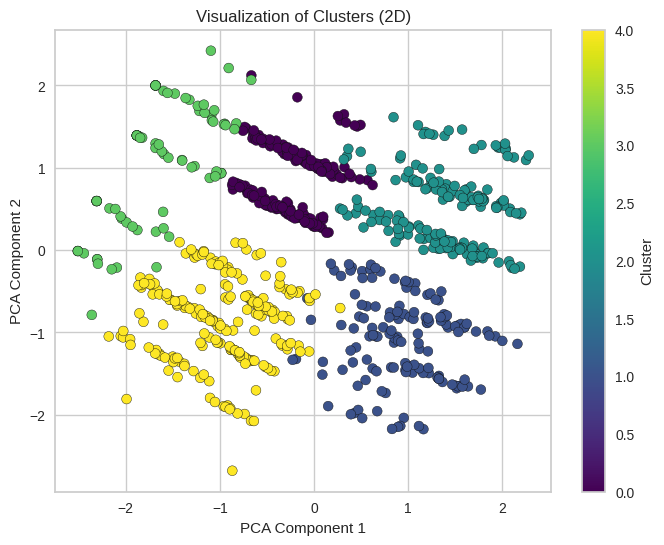

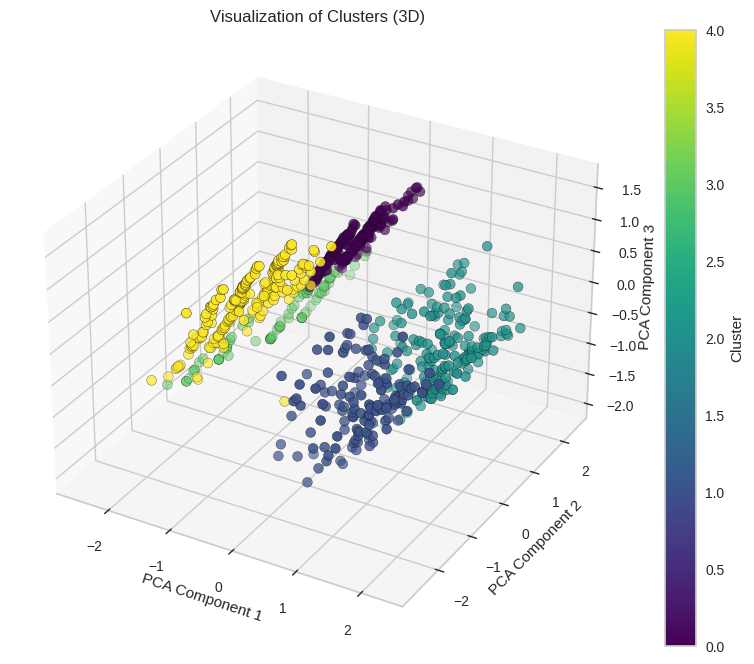

In [89]:

# Sử dụng class
if __name__ == "__main__":
    file_path = '/content/drive/My Drive/Colab Notebooks/NCKH (Ph. Danh Hường)/Data thô/data_final.xlsx'
    selector = FeatureSelectorClusterEvaluator(file_path)

    # Load và tách dữ liệu
    selector.load_and_split_data()

    # Chọn đặc trưng
    selector.feature_selection(n_clusters=5)

    # Đánh giá cụm
    results = selector.evaluate_clustering(n_clusters=5)
    # Trực quan hóa cụm
    selector.visualize_clusters_2d()
    selector.visualize_clusters_3d()

# ***`Forward Selection for Agglomerative Clustering`***

In [ ]:
X_non_noise_final =pd.read_excel('/content/drive/My Drive/Colab Notebooks/NCKH (Ph. Danh Hường)/Data thô/data_final.xlsx')
X_non_noise_final = X_non_noise_final.drop(columns = ['Unnamed: 0'])
X_non_noise_final_continuous = X_non_noise_final.iloc[:, :6]
X_non_noise_final_categorical = X_non_noise_final.iloc[:, 6:]

Binary Feature Name: Positive_High_revenue_Low_Rating_High
Silhouette Avg: 0.41016403
Binary Feature Name: Followers_Low_revenue_Low_Positive_High
Silhouette Avg: 0.39388677
Binary Feature Name: Chat_Response_High
Silhouette Avg: 0.37711415
Binary Feature Name: Chat_Low_revenue_Low_Positive_High
Silhouette Avg: 0.4465177
Binary Feature Name: Chat_Low_Year_Low_Followers_Low_revenue_Low
Silhouette Avg: 0.40882227
Binary Feature Name: Year_Low_Positive_High
Silhouette Avg: 0.39341167
Binary Feature Name: Year_High_revenue_Low
Silhouette Avg: 0.44155687
Binary Feature Name: Year_Low_revenue_Low_Rating_High
Silhouette Avg: 0.38766265
Binary Feature Name: Followers_Low_Positive_High_Rating_High
Silhouette Avg: 0.42374372
Binary Feature Name: Chat_Low_Followers_Low_revenue_Low_Rating_High
Silhouette Avg: 0.40764144
Binary Feature Name: Chat_Low_Followers_Low_Positive_High
Silhouette Avg: 0.40948904
Binary Feature Name: Chat_Low_Followers_Low_Positive_Medium_revenue_Low
Silhouette Avg: 0.43451

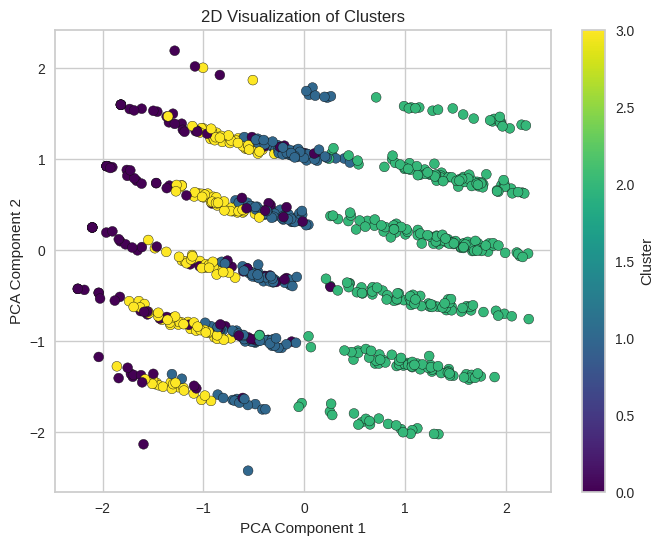

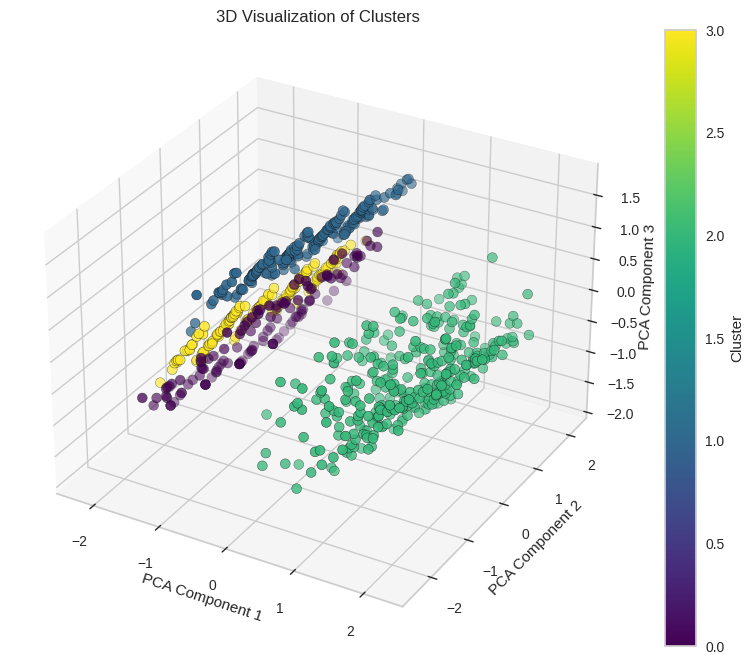

In [91]:
import pandas as pd
from gower import gower_matrix
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score


class GowerAgglomerativeFeatureSelector:
    def __init__(self, continuous_data, categorical_data):
        """
        Khởi tạo class với dữ liệu liên tục và phân loại.
        :param continuous_data: Dữ liệu liên tục.
        :param categorical_data: Dữ liệu phân loại.
        """
        self.continuous_data = continuous_data
        self.categorical_data = categorical_data
        self.selected_features = continuous_data.copy()
        self.best_silhouette_score = -1
        self.clusters = None

    @staticmethod
    def calculate_gower_distance(data):
        """
        Tính khoảng cách Gower cho dữ liệu hỗn hợp.
        """
        return gower_matrix(data)

    def select_features(self, n_clusters=4):
        """
        Chọn các đặc trưng tốt nhất dựa trên Silhouette Score.
        :param n_clusters: Số cụm cần phân chia.
        """
        binary_features = self.categorical_data.copy()

        while not binary_features.empty:
            best_feature = None
            for binary_feature_name in binary_features.columns:
                print("Binary Feature Name:", binary_feature_name)

                # Thêm biến nhị phân hiện tại vào tập dữ liệu
                current_features = self.selected_features.copy()
                current_features[binary_feature_name] = binary_features[binary_feature_name]

                # Tính khoảng cách Gower
                gower_distances = self.calculate_gower_distance(current_features)

                # Áp dụng Agglomerative Clustering
                clustering = AgglomerativeClustering(
                    n_clusters=n_clusters, metric="precomputed", linkage="average")
                clusters = clustering.fit_predict(gower_distances)

                # Tính Silhouette Score
                silhouette_avg = silhouette_score(gower_distances, clusters, metric="precomputed")
                print("Silhouette Avg:", silhouette_avg)

                # Cập nhật nếu cải thiện Silhouette Score
                if silhouette_avg > self.best_silhouette_score:
                    self.best_silhouette_score = silhouette_avg
                    best_feature = binary_feature_name
                    self.clusters = clusters

            print("Best Silhouette Score:", self.best_silhouette_score)

            # Nếu không có biến nào cải thiện Silhouette Score, dừng
            if best_feature is None:
                break

            # Thêm biến tốt nhất vào tập biến đã chọn
            self.selected_features[best_feature] = binary_features[best_feature]
            binary_features = binary_features.drop(columns=[best_feature])

    def evaluate_clustering(self):
        """
        Đánh giá cụm bằng các chỉ số khác nhau.
        """
        # Thêm nhãn cụm vào DataFrame
        self.selected_features['Cluster'] = self.clusters

        # Tính khoảng cách Gower và các chỉ số đánh giá
        gower_distances = self.calculate_gower_distance(self.selected_features)
        silhouette_avg = silhouette_score(gower_distances, self.selected_features['Cluster'], metric="precomputed")
        davies_bouldin_avg = davies_bouldin_score(gower_distances, self.selected_features['Cluster'])
        calinski_harabasz_avg = calinski_harabasz_score(gower_distances, self.selected_features['Cluster'])

        print("Silhouette Score (dữ liệu hỗn hợp):", silhouette_avg)
        print("Davies-Bouldin Index (dữ liệu hỗn hợp):", davies_bouldin_avg)
        print("Calinski-Harabasz Index (CHI):", calinski_harabasz_avg)

        return {
            "Silhouette Score": silhouette_avg,
            "Davies-Bouldin Index": davies_bouldin_avg,
            "Calinski-Harabasz Index": calinski_harabasz_avg,
        }

    def visualize_clusters_2d(self):
        """
        Trực quan hóa các cụm trong không gian 2D sử dụng PCA.
        """
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(self.selected_features.drop(columns=['Cluster']))

        plt.figure(figsize=(8, 6))
        plt.scatter(X_pca[:, 0], X_pca[:, 1], c=self.selected_features['Cluster'], cmap='viridis', edgecolor='k', s=50)
        plt.title('2D Visualization of Clusters')
        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')
        plt.colorbar(label='Cluster')
        plt.show()

    def visualize_clusters_3d(self):
        """
        Trực quan hóa các cụm trong không gian 3D sử dụng PCA.
        """
        pca = PCA(n_components=3)
        X_pca = pca.fit_transform(self.selected_features.drop(columns=['Cluster']))

        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
                              c=self.selected_features['Cluster'], cmap='viridis', edgecolor='k', s=50)

        ax.set_title('3D Visualization of Clusters')
        ax.set_xlabel('PCA Component 1')
        ax.set_ylabel('PCA Component 2')
        ax.set_zlabel('PCA Component 3')

        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label('Cluster')
        plt.show()


# Sử dụng class
if __name__ == "__main__":
    # Đọc dữ liệu
    file_path = '/content/drive/My Drive/Colab Notebooks/NCKH (Ph. Danh Hường)/Data thô/data_final.xlsx'
    X_non_noise_final = pd.read_excel(file_path).drop(columns=['Unnamed: 0'])
    X_non_noise_final_continuous = X_non_noise_final.iloc[:, :6]
    X_non_noise_final_categorical = X_non_noise_final.iloc[:, 6:]

    # Tạo đối tượng GowerAgglomerativeFeatureSelector
    selector = GowerAgglomerativeFeatureSelector(X_non_noise_final_continuous, X_non_noise_final_categorical)

    # Chọn đặc trưng
    selector.select_features(n_clusters=4)

    # Đánh giá cụm
    results = selector.evaluate_clustering()
    # Trực quan hóa cụm
    selector.visualize_clusters_2d()
    selector.visualize_clusters_3d()

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist, squareform

# Hàm tính khoảng cách Gower
def gower_distance(data):
    return gower_matrix(data)

X_continuous = X_non_noise_final_continuous
binary_features = X_non_noise_final_categorical
best_silhouette_score = -1
selected_features = X_continuous.copy()


while not binary_features.empty:
    best_feature = None
    for binary_feature_name in binary_features.columns:
        print("Binary Feature Name là: ", binary_feature_name)

        # Thêm biến nhị phân hiện tại vào tập dữ liệu
        current_features = selected_features.copy()
        current_features[binary_feature_name] = binary_features[binary_feature_name]
        print("Current Features: ", current_features.columns)

        # Tính khoảng cách Gower cho dữ liệu hỗn hợp
        gower_distances = gower_distance(current_features)

        # Áp dụng Agglomerative Clustering
        clustering = AgglomerativeClustering(n_clusters=4, metric="precomputed", linkage="average")
        clusters = clustering.fit_predict(gower_distances)

        # Tính Silhouette Score với khoảng cách Gower
        silhouette_avg = silhouette_score(gower_distances, clusters, metric="precomputed")
        print("Silhouette Avg:", silhouette_avg)

        # Kiểm tra nếu Silhouette Score cải thiện, cập nhật biến tốt nhất
        if silhouette_avg > best_silhouette_score:
            best_silhouette_score = silhouette_avg
            best_feature = binary_feature_name
    print("Best Silhouette Score: ", best_silhouette_score)
    print('Kết thúc vòng lặp.')

    # Nếu không có biến nào cải thiện Silhouette Score, dừng
    if best_feature is None:
        break

    # Thêm biến tốt nhất vào tập biến đã chọn
    selected_features[best_feature] = binary_features[best_feature]
    print("Selected Features: ", selected_features)

    # Loại bỏ biến đã chọn khỏi danh sách biến còn lại
    binary_features = binary_features.drop(columns=[best_feature])
    print("Binary Features: ", binary_features.columns)

# Thêm nhãn cụm vào DataFrame
selected_features['Cluster'] = clusters

# Tính các chỉ số đánh giá khác
gower_distances = gower_distance(selected_features)

# In kết quả
print("Selected features: ", selected_features.columns[:-1])
print("Best Silhouette Score (dữ liệu hỗn hợp):", best_silhouette_score)


Binary Feature Name là:  revenue_Low_Year_Medium_Followers_Low
Current Features:  Index(['revenue', 'Year_Joined', 'Followers', 'Chat Resopnse',
       'Rating_quality', 'Positive_quality',
       'revenue_Low_Year_Medium_Followers_Low'],
      dtype='object')
Silhouette Avg: 0.37504274
Binary Feature Name là:  revenue_Low_Rating_Medium_Followers_Low
Current Features:  Index(['revenue', 'Year_Joined', 'Followers', 'Chat Resopnse',
       'Rating_quality', 'Positive_quality',
       'revenue_Low_Rating_Medium_Followers_Low'],
      dtype='object')
Silhouette Avg: 0.3692638
Binary Feature Name là:  Chat_Resopnse_High
Current Features:  Index(['revenue', 'Year_Joined', 'Followers', 'Chat Resopnse',
       'Rating_quality', 'Positive_quality', 'Chat_Resopnse_High'],
      dtype='object')
Silhouette Avg: 0.3451965
Binary Feature Name là:  revenue_Low_Year_High_Followers_Low_Chat_Low
Current Features:  Index(['revenue', 'Year_Joined', 'Followers', 'Chat Resopnse',
       'Rating_quality', 'P

In [ ]:
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from gower import gower_matrix

# Danh sách các cột đặc trưng
feature_names = ['revenue', 'Year_Joined', 'Followers', 'Chat Resopnse',
       'Rating_quality', 'Positive_quality',
       'Rating_Medium_Followers_Low_Chat_Low',
       'Rating_High_revenue_Low_Followers_Low_Chat_Low',
       'revenue_Low_Rating_Medium_Chat_Low']
# Chọn dữ liệu không nhiễu với các đặc trưng cần thiết
X_non_noise_final_2 = X_non_noise_final[selected_features]

# Tính khoảng cách Gower cho dữ liệu hỗn hợp
gower_distances = gower_matrix(X_non_noise_final_2)
clustering = AgglomerativeClustering(n_clusters=4, linkage='average', metric='precomputed')
fagglabels = clustering.fit_predict(gower_distances)

# # Thêm nhãn cụm vào DataFrame gốc
X_non_noise_final_2['Cluster'] = fagglabels

# Tính Silhouette Score với khoảng cách Gower
silhouette_avg = silhouette_score(gower_distances, X_non_noise_final_2['Cluster'], metric="precomputed")

# Tính Davies-Bouldin Index với khoảng cách Gower
davies_bouldin_avg = davies_bouldin_score(gower_distances, X_non_noise_final_2['Cluster']) # Calculate DBI using the original data

# # Tính Calinski-Harabasz Index với khoảng cách Gower
chi = calinski_harabasz_score(gower_distances, X_non_noise_final_2['Cluster'])

# In kết quả đánh giá
print("Silhouette Score (dữ liệu hỗn hợp):", silhouette_avg)
print("Davies-Bouldin Index (dữ liệu hỗn hợp):", davies_bouldin_avg)
print("Calinski-Harabasz Index (CHI):", chi)

Silhouette Score (dữ liệu hỗn hợp): 0.55252355
Davies-Bouldin Index (dữ liệu hỗn hợp): 0.6281051039092262
Calinski-Harabasz Index (CHI): 1451.0593305951759


In [ ]:
X_non_noise_final_2['Cluster'].unique()

array([2, 0, 1, 5, 3, 4])

# ***`Visualize `***

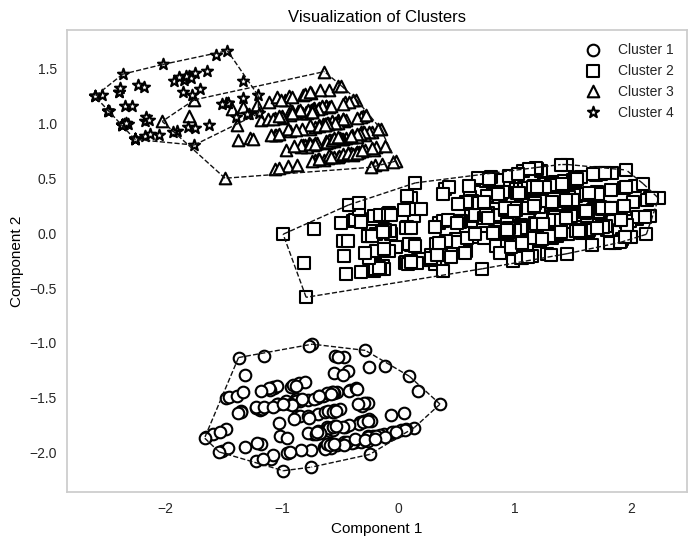

In [ ]:
# Áp dụng PCA để giảm chiều về 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_non_noise_final_2)

# Giả sử số cụm là 4
num_clusters = 4

# Tạo danh sách các ký hiệu khác nhau (đủ cho 4 cụm)
markers = ['o', 's', '^', '*']  # Hình tròn, vuông, tam giác, thoi

# Vẽ biểu đồ với các cụm màu đen, nền trắng
plt.figure(figsize=(8, 6))
for cluster in range(num_clusters):
    # Lọc điểm thuộc cụm hiện tại
    cluster_points = X_pca[np.array(fagglabels) == cluster]

    # Vẽ các điểm dữ liệu với viền đậm
    plt.scatter(
        cluster_points[:, 0],
        cluster_points[:, 1],
        marker=markers[cluster],
        color='white',  # Màu trắng bên trong
        edgecolor='black',  # Viền màu đen
        linewidth=1.5,  # Độ dày viền
        s=70,  # Kích thước marker
        label=f'Cluster {cluster + 1}'
    )

    # Vẽ đường viền bao quanh cụm (Convex Hull)
    if len(cluster_points) > 2:  # Đảm bảo có đủ điểm để tạo Convex Hull
        hull = ConvexHull(cluster_points)
        for simplex in hull.simplices:
            plt.plot(
                cluster_points[simplex, 0],
                cluster_points[simplex, 1],
                'k--',  # Đường nét đứt màu đen
                linewidth=1
            )

# Thêm tiêu đề, nhãn và chú thích
plt.title('Visualization of Clusters', color='black')  # Chữ màu đen
plt.xlabel('Component 1', color='black')  # Chữ màu đen
plt.ylabel('Component 2', color='black')  # Chữ màu đen
plt.grid(False)  # Không có lưới
plt.legend()
plt.show()

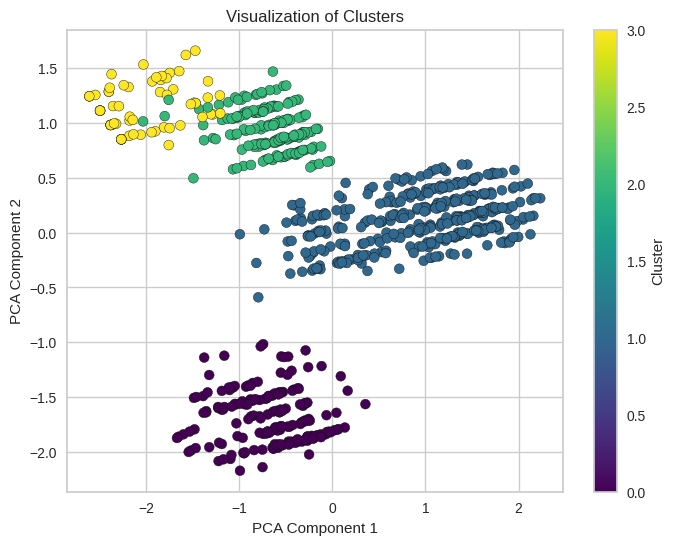

In [ ]:
# Áp dụng PCA để giảm chiều về 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_non_noise_final_2)

# Tạo biểu đồ với các cụm màu sắc khác nhau
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=fagglabels, cmap='viridis', edgecolor='k', s=50)
plt.title('Visualization of Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

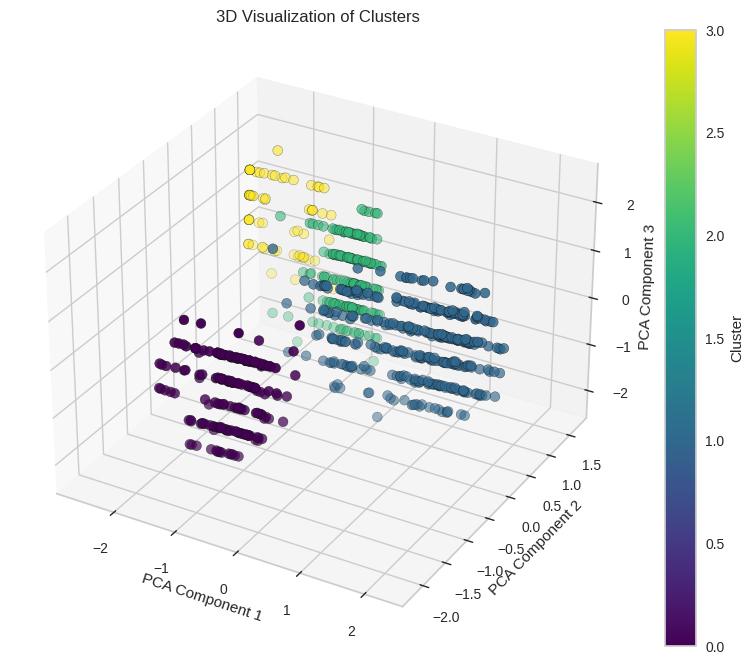

In [ ]:
# Áp dụng PCA để giảm chiều về 3D
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_non_noise_final_2)

# Tạo biểu đồ 3D với các cụm màu sắc khác nhau
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=fagglabels, cmap='viridis', edgecolor='k', s=50)

# Thêm nhãn và tiêu đề
ax.set_title('3D Visualization of Clusters')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')

# Thêm thanh màu (colorbar) để thể hiện các cụm
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Cluster')

plt.show()

In [ ]:
import plotly.express as px
import pandas as pd
from sklearn.decomposition import PCA

# Áp dụng PCA để giảm chiều về 3D
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_non_noise_final_2)

# Giả sử fagglabels là các nhãn cụm (thay đổi tùy theo dữ liệu của bạn)
df = pd.DataFrame(X_pca, columns=['PCA Component 1', 'PCA Component 2', 'PCA Component 3'])
df['Cluster'] = fagglabels  # Gắn nhãn cụm vào DataFrame

# Sử dụng Plotly để vẽ biểu đồ 3D với các cụm màu sắc khác nhau
fig = px.scatter_3d(df,
                    x='PCA Component 1',
                    y='PCA Component 2',
                    z='PCA Component 3',
                    color='Cluster',   # Tô màu theo nhãn cụm
                    title='3D Visualization of Clusters',
                    color_continuous_scale='viridis',  # Bảng màu
                    labels={'Cluster': 'Cluster'},    # Đặt nhãn cho cột cụm
                    opacity=0.7)  # Đặt độ trong suốt của các điểm

# Hiển thị biểu đồ 3D tương tác (xoay, zoom)
fig.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



# ***`Forward Selection for GMM`***

In [ ]:
X_non_noise_final =pd.read_excel('/content/drive/My Drive/Colab Notebooks/NCKH (Ph. Danh Hường)/Data thô/data_final.xlsx')
X_non_noise_final = X_non_noise_final.drop(columns = ['Unnamed: 0'])
X_continuous = X_non_noise_final.iloc[:, :6]
binary_features = X_non_noise_final.iloc[:, 6:]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# Giả sử bạn đã chuẩn bị dữ liệu X_continuous và binary_features
# X_continuous: Dữ liệu liên tục (DataFrame)
# binary_features: Dữ liệu nhị phân (DataFrame)

# Bắt đầu với các đặc trưng liên tục
selected_features = X_continuous.copy()
best_silhouette_score = -1

while not binary_features.empty:
    best_feature = None

    # Duyệt qua các biến nhị phân
    for binary_feature_name in binary_features.columns:
        print("Đang kiểm tra biến nhị phân: ", binary_feature_name)

        # Thêm biến nhị phân hiện tại vào tập dữ liệu
        current_features = selected_features.copy()
        current_features[binary_feature_name] = binary_features[binary_feature_name]
        print("Tập dữ liệu hiện tại: ", current_features.columns)

        # Áp dụng Gaussian Mixture Model (GMM)
        gmm = GaussianMixture(n_components=3, covariance_type="spherical", random_state=42)
        gmm.fit(current_features)

        # Dự đoán nhãn cụm
        clusters = gmm.predict(current_features)

        # Tính Silhouette Score (nếu có nhiều hơn 1 cụm)
        if len(set(clusters)) > 1:
            silhouette_avg = silhouette_score(current_features, clusters)
        else:
            silhouette_avg = -1  # Không thể tính với chỉ 1 cụm

        print(f"Silhouette Score của {binary_feature_name}: {silhouette_avg}")

        # Kiểm tra nếu Silhouette Score cải thiện, cập nhật biến tốt nhất
        if silhouette_avg > best_silhouette_score:
            best_silhouette_score = silhouette_avg
            best_feature = binary_feature_name

    print("Silhouette Score tốt nhất hiện tại: ", best_silhouette_score)

    # Nếu không có biến nào cải thiện Silhouette Score, dừng vòng lặp
    if best_feature is None:
        print("Không có biến nào cải thiện Silhouette Score. Kết thúc.")
        break

    # Thêm biến nhị phân tốt nhất vào tập đã chọn
    selected_features[best_feature] = binary_features[best_feature]
    print(f"Đã chọn biến: {best_feature}. Các biến đã chọn: ", selected_features.columns)

    # Loại bỏ biến đã chọn khỏi danh sách biến nhị phân còn lại
    binary_features = binary_features.drop(columns=[best_feature])
    print("Danh sách biến nhị phân còn lại: ", binary_features.columns)

# In kết quả cuối cùng
print("\nCác biến được chọn cuối cùng: ", selected_features.columns)
print("Silhouette Score tốt nhất đạt được: ", best_silhouette_score)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Đang kiểm tra biến nhị phân:  Positive_High_revenue_Low_Rating_High
Tập dữ liệu hiện tại:  Index(['revenue', 'Year_Joined', 'Followers', 'Chat Resopnse',
       'Rating_quality', 'Positive_quality',
       'Positive_High_revenue_Low_Rating_High'],
      dtype='object')
Silhouette Score của Positive_High_revenue_Low_Rating_High: 0.27346079212490926
Đang kiểm tra biến nhị phân:  Followers_Low_revenue_Low_Positive_High
Tập dữ liệu hiện tại:  Index(['revenue', 'Year_Joined', 'Followers', 'Chat Resopnse',
       'Rating_quality', 'Positive_quality',
       'Followers_Low_revenue_Low_Positive_High'],
      dtype='object')
Silhouette Score của Followers_Low_revenue_Low_Positive_High: 0.27539854456734847
Đang kiểm tra biến nhị phân:  Chat_Response_High
Tập dữ liệu hiện tại:  Index(['revenue', 'Year_Joined', 'Followers', 'Chat Resopnse',
       'Rating_quality', 'Positive_quality', 'Chat_Response_High'],
      dtype='object')
Silhouette Score của Chat_Response_High: 0.28293375855913866
Đang kiể

In [ ]:
selected_features = ['revenue', 'Year_Joined', 'Followers', 'Chat Resopnse',
       'Rating_quality', 'Positive_quality',
       'Chat_Low_revenue_Low_Positive_High',
       'Chat_Low_Followers_Low_Positive_High',
       'Chat_Low_Followers_Low_Positive_Medium_revenue_Low',
       'Followers_Low_revenue_Low_Positive_High']

fgmm = GaussianMixture(n_components=3, covariance_type='spherical', max_iter=300, random_state=42)

fgmm.fit(X_non_noise_final[selected_features])
fgmmlabels = fgmm.predict(X_non_noise_final[selected_features])

silhouette_avg = silhouette_score(X_non_noise_final[selected_features], fgmmlabels)
dbi = davies_bouldin_score(X_non_noise_final[selected_features], fgmmlabels)
chi = calinski_harabasz_score(X_non_noise_final[selected_features], fgmmlabels)

print("Silhouette Score (dữ liệu hỗn hợp):", silhouette_avg)
print("Davies-Bouldin Index (dữ liệu hỗn hợp):", dbi)
print(f"Calinski-Harabasz Index (CHI): {chi}")

Silhouette Score (dữ liệu hỗn hợp): 0.34136878510078283
Davies-Bouldin Index (dữ liệu hỗn hợp): 1.234350664778489
Calinski-Harabasz Index (CHI): 373.19061015280977


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


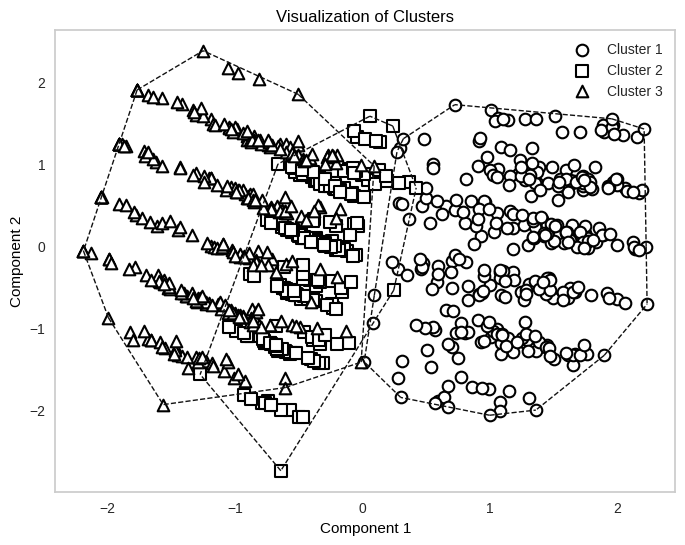

In [ ]:
# Áp dụng PCA để giảm chiều về 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_non_noise_final[selected_features])

# Giả sử số cụm là 3
num_clusters = 3

# Tạo danh sách các ký hiệu khác nhau (đủ cho 3 cụm)
markers = ['o', 's', '^']  # Hình tròn, vuông, tam giác

# Vẽ biểu đồ với các cụm màu đen, nền trắng
plt.figure(figsize=(8, 6))
for cluster in range(num_clusters):
    # Lọc điểm thuộc cụm hiện tại
    cluster_points = X_pca[np.array(fgmmlabels) == cluster]

    # Vẽ các điểm dữ liệu với viền đậm
    plt.scatter(
        cluster_points[:, 0],
        cluster_points[:, 1],
        marker=markers[cluster],
        color='white',  # Màu trắng bên trong
        edgecolor='black',  # Viền màu đen
        linewidth=1.5,  # Độ dày viền
        s=70,  # Kích thước marker
        label=f'Cluster {cluster + 1}'
    )

    # Vẽ đường viền bao quanh cụm (Convex Hull)
    if len(cluster_points) > 2:  # Đảm bảo có đủ điểm để tạo Convex Hull
        hull = ConvexHull(cluster_points)
        for simplex in hull.simplices:
            plt.plot(
                cluster_points[simplex, 0],
                cluster_points[simplex, 1],
                'k--',  # Đường nét đứt màu đen
                linewidth=1
            )

# Thêm tiêu đề, nhãn và chú thích
plt.title('Visualization of Clusters', color='black')  # Chữ màu đen
plt.xlabel('Component 1', color='black')  # Chữ màu đen
plt.ylabel('Component 2', color='black')  # Chữ màu đen
plt.grid(False)  # Không có lưới
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


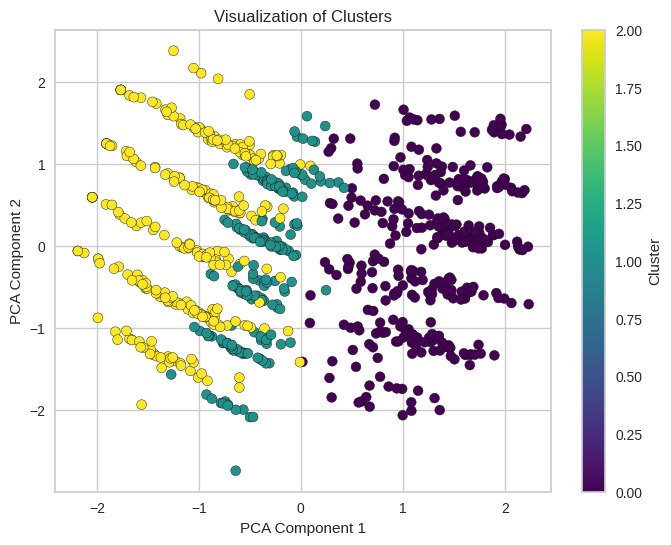

In [ ]:
# Áp dụng PCA để giảm chiều về 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_non_noise_final[selected_features])

# Tạo biểu đồ với các cụm màu sắc khác nhau
plt.figure(figsize=(8, 6))
# Use fgmmlabels instead of fgmm for the color argument
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=fgmmlabels, cmap='viridis', edgecolor='k', s=50)
plt.title('Visualization of Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


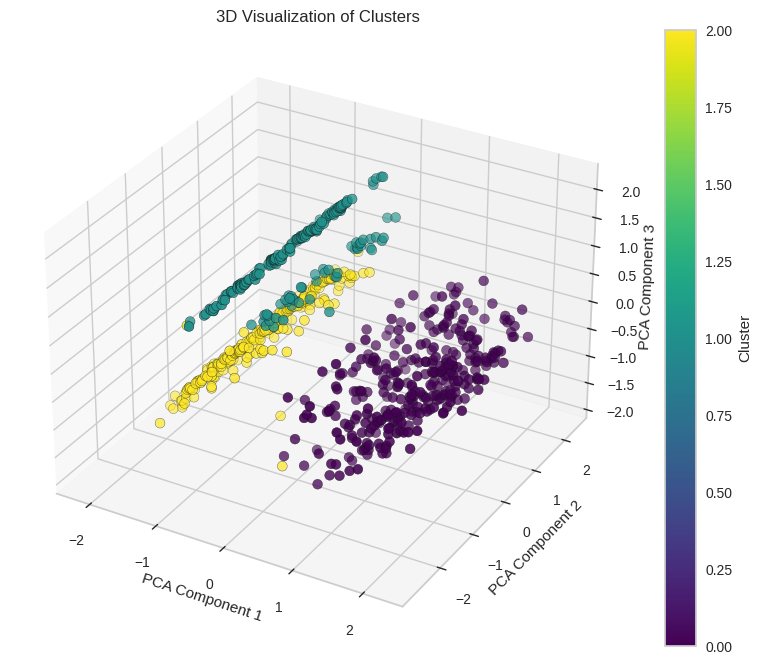

In [ ]:
# Áp dụng PCA để giảm chiều về 3D
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_non_noise_final[selected_features])

# Tạo biểu đồ 3D với các cụm màu sắc khác nhau
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=fgmmlabels, cmap='viridis', edgecolor='k', s=50)

# Thêm nhãn và tiêu đề
ax.set_title('3D Visualization of Clusters')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')

# Thêm thanh màu (colorbar) để thể hiện các cụm
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Cluster')

plt.show()

# ***`CLUSTER PROFILING`***

In [ ]:
X_non_noise_final_1.head(2)

revenue  Year_Joined  Followers  Chat Resopnse  Rating_quality  \
0 -0.326840    -0.279443  -0.143533      -0.819518        0.517466   
1 -0.143226    -0.972848   0.031235      -0.819518        0.539159   

   Positive_quality  Chat_Low_Year_Low_Followers_Low_revenue_Low  \
0          0.731572                                            1   
1          0.189270                                            0   

   Year_Low_Positive_High  Cluster  
0                       1        2  
1                       0        2

Cluster
2    233
3    206
1    185
4    145
0     79
Name: count, dtype: int64


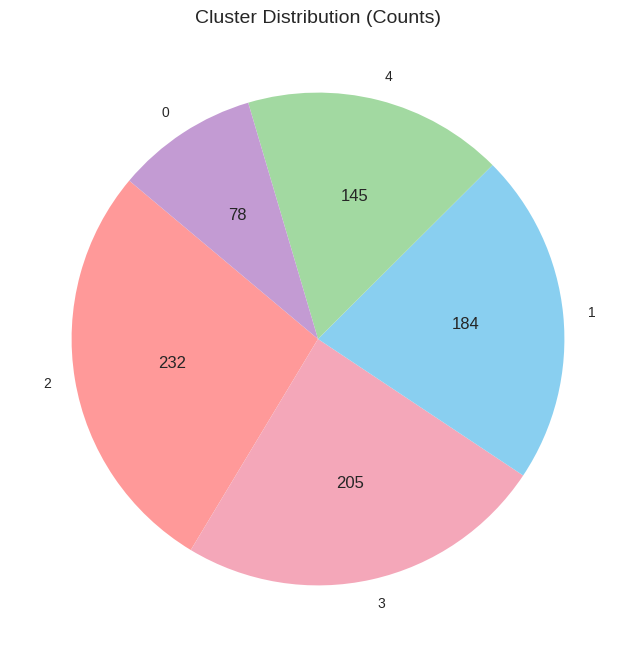

In [ ]:
continuous_variables = ['revenue', 'Year_Joined', 'Followers', 'Chat Resopnse', 'Rating_quality', 'Positive_quality',]
binary_variables = ['Chat_Low_Year_Low_Followers_Low_revenue_Low', 'Year_Low_Positive_High']
cluster_counts = X_non_noise_final_1['Cluster'].value_counts()
print(cluster_counts)

# Vẽ biểu đồ tròn (pie chart)
colors = ['#FF9999', '#F4A7B9', '#89CFF0', '#A2D9A1', '#C39BD3']
plt.figure(figsize=(8, 8))
plt.pie(cluster_counts, labels=cluster_counts.index, autopct=lambda p: f'{int(p * sum(cluster_counts) / 100)}',
        startangle=140, colors=colors)
plt.title('Cluster Distribution (Counts)', fontsize=14)
plt.show()

In [ ]:
# Tính giá trị chi tiết hơn cho các biến liên tục
continuous_detailed_summary = X_non_noise_final_1.groupby('Cluster')[continuous_variables].agg(['mean', 'std', 'min', 'max', 'median'])
continuous_detailed_summary = pd.DataFrame(continuous_detailed_summary)

# Tính giá trị chi tiết hơn cho các biến nhị phân
binary_detailed_summary = X_non_noise_final_1.groupby('Cluster')[binary_variables].agg(['mean', 'std', 'min', 'max', 'median']) * 100
binary_detailed_summary = pd.DataFrame(binary_detailed_summary)

# Hiển thị kết quả
print("Continuous Variable Detailed Summary:")
print(continuous_detailed_summary)
print("\nBinary Variable Detailed Summary (Percentage):")
print(binary_detailed_summary)


Continuous Variable Detailed Summary:
          revenue                                         Year_Joined  \
             mean       std       min       max    median        mean   
Cluster                                                                 
0       -0.303502  0.091295 -0.336892  0.143819 -0.335240    0.334967   
1       -0.004932  0.419747 -0.336892  1.340598 -0.193682    0.841250   
2       -0.250495  0.185783 -0.336892  1.011583 -0.313694   -0.877617   
3       -0.256029  0.175297 -0.336892  0.987696 -0.308105    0.824620   
4       -0.053123  0.354798 -0.336892  1.340598 -0.184591   -0.757654   

                                                 ... Rating_quality            \
              std       min       max    median  ...           mean       std   
Cluster                                          ...                            
0        0.785028 -1.666254  1.800773  0.413962  ...      -1.030921  0.580241   
1        0.473368  0.413962  1.800773  1.107368  ... 

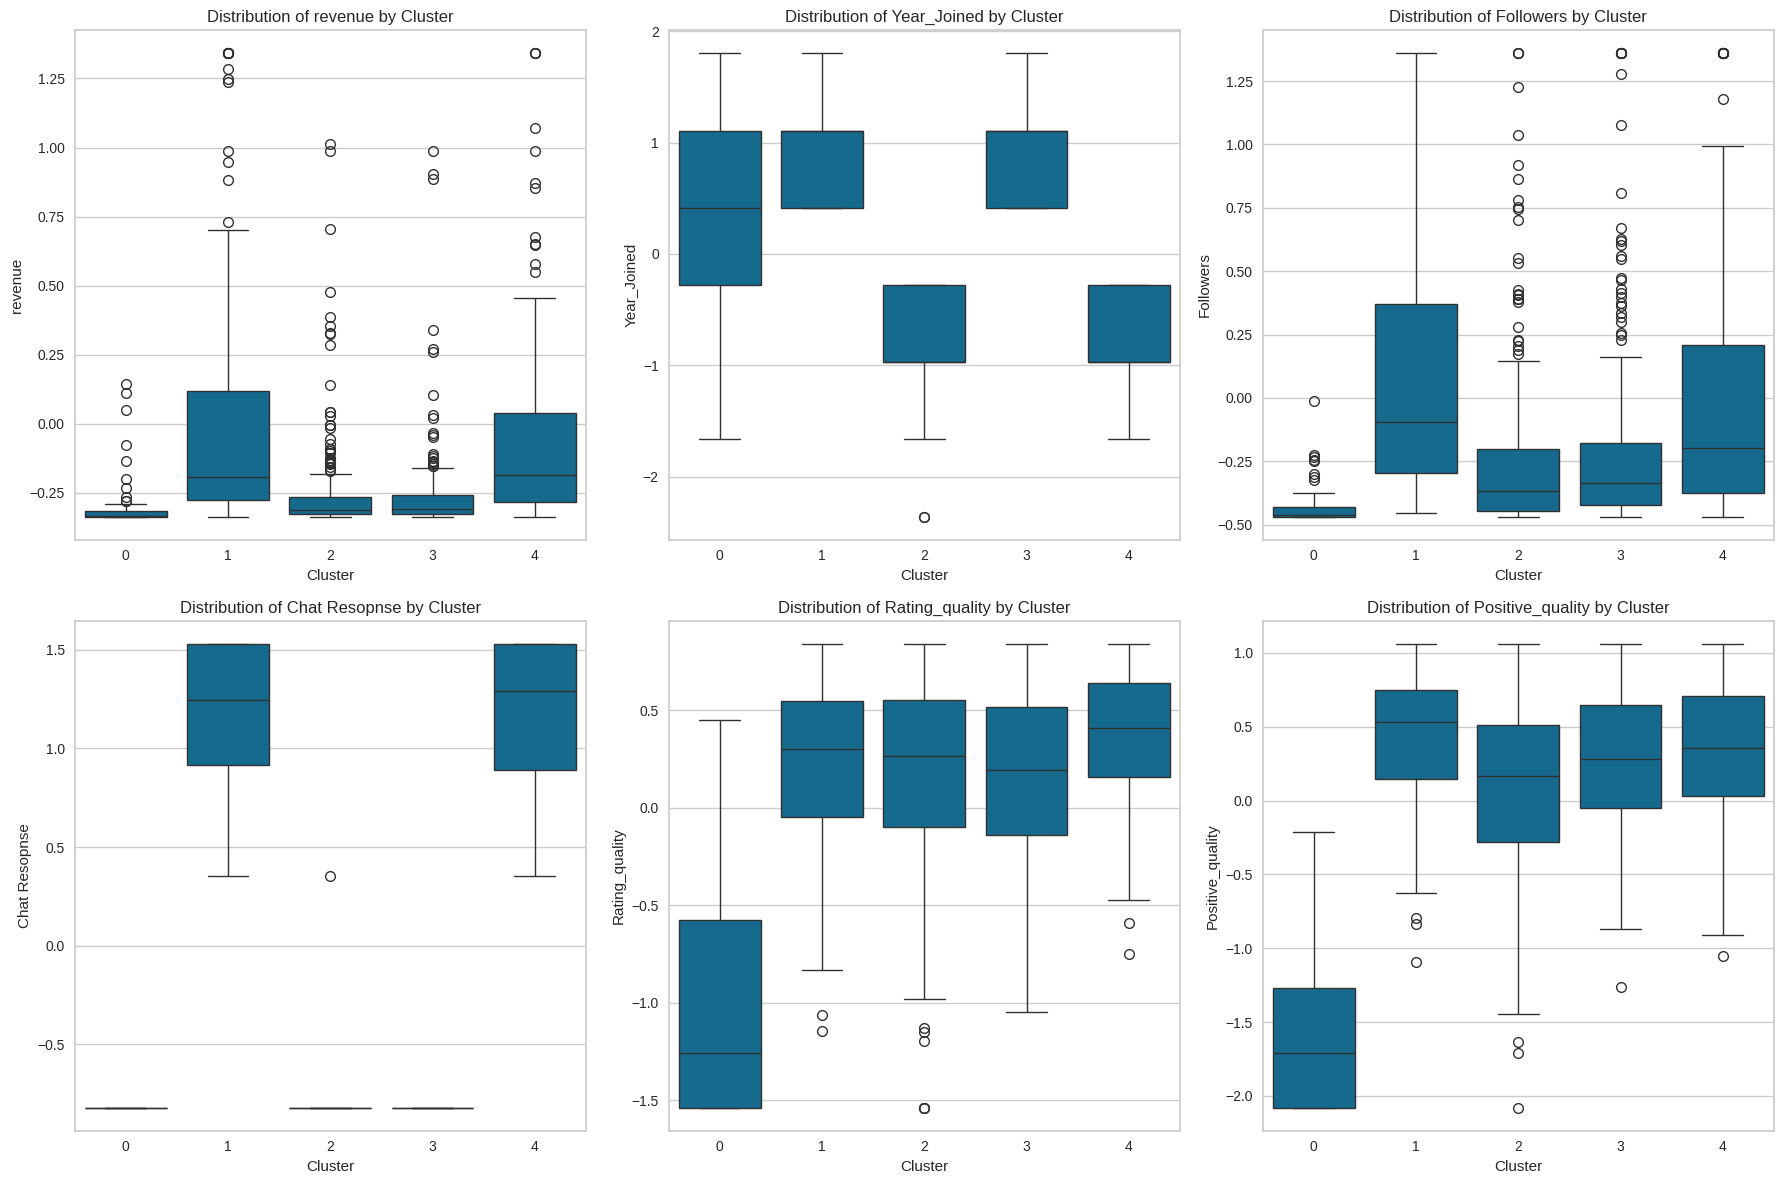

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Tạo subplot 2 dòng, 3 cột
fig, axes = plt.subplots(2, 3, figsize=(18, 12))  # Điều chỉnh figsize để phù hợp

# Lặp qua từng biến liên tục và vẽ boxplot
for idx, col in enumerate(continuous_variables):
    row, col_idx = divmod(idx, 3)  # Tính vị trí dòng và cột
    sns.boxplot(x='Cluster', y=col, data=X_non_noise_final_1, ax=axes[row, col_idx])
    axes[row, col_idx].set_title(f'Distribution of {col} by Cluster')
    axes[row, col_idx].set_xlabel('Cluster')
    axes[row, col_idx].set_ylabel(col)

# Ẩn các ô trống nếu số biến ít hơn số subplot
if len(continuous_variables) < 6:
    for idx in range(len(continuous_variables), 6):
        row, col_idx = divmod(idx, 3)
        fig.delaxes(axes[row, col_idx])

plt.tight_layout()
plt.show()


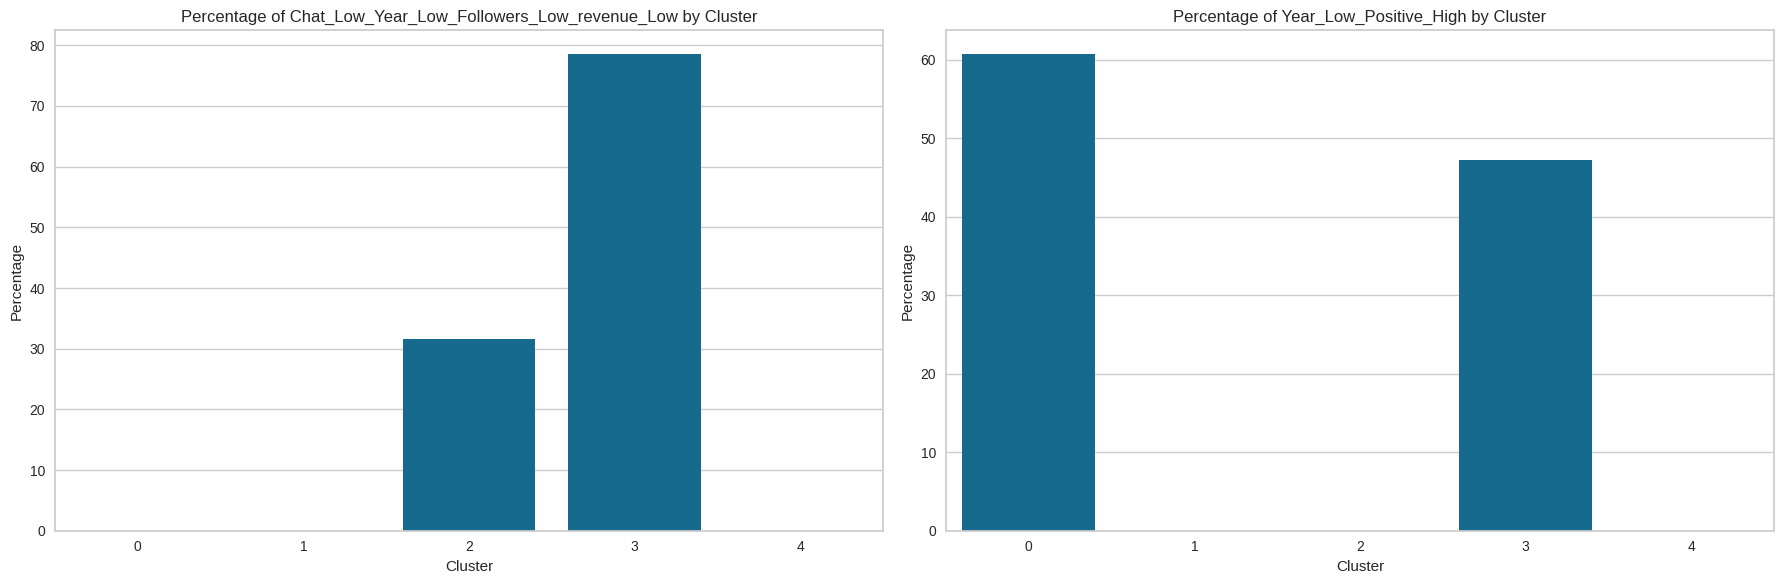

In [ ]:
# Tạo subplot 1 dòng, 2 cột
fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # Điều chỉnh figsize để phù hợp

# Lặp qua từng biến nhị phân và vẽ bar plot
for idx, col in enumerate(binary_variables[:2]):  # Hiển thị 2 biến trên 1 dòng
    sns.barplot(
        x=X_non_noise_final_1['Cluster'].unique(),
        y=X_non_noise_final_1.groupby('Cluster')[col].mean() * 100,
        ax=axes[idx]
    )
    axes[idx].set_title(f'Percentage of {col} by Cluster')
    axes[idx].set_xlabel('Cluster')
    axes[idx].set_ylabel('Percentage')

plt.tight_layout()
plt.show()

# ***`So sánh giữa các cụm`***

In [ ]:
from scipy.stats import f_oneway

# Kiểm định ANOVA
anova_results = {}
for col in continuous_variables:
    groups = [X_non_noise_final_1[X_non_noise_final_1['Cluster'] == cluster][col] for cluster in X_non_noise_final_1['Cluster'].unique()]
    anova_results[col] = f_oneway(*groups)

print("ANOVA Results for Continuous Variables:")
for col, result in anova_results.items():
    print(f"{col}: F-statistic = {result.statistic:.3f}, p-value = {result.pvalue:.3f}")


ANOVA Results for Continuous Variables:
revenue: F-statistic = 36.883, p-value = 0.000
Year_Joined: F-statistic = 522.085, p-value = 0.000
Followers: F-statistic = 30.588, p-value = 0.000
Chat Resopnse: F-statistic = 3221.113, p-value = 0.000
Rating_quality: F-statistic = 140.201, p-value = 0.000
Positive_quality: F-statistic = 255.010, p-value = 0.000


In [ ]:
from scipy.stats import chi2_contingency

# Kiểm định Chi-squared
chi2_results = {}
for col in binary_variables:
    contingency_table = pd.crosstab(X_non_noise_final_1['Cluster'], X_non_noise_final_1[col])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    chi2_results[col] = {'chi2': chi2, 'p-value': p}

print("Chi-squared Test Results for Binary Variables:")
for col, result in chi2_results.items():
    print(f"{col}: Chi2 = {result['chi2']:.3f}, p-value = {result['p-value']:.3f}")


Chi-squared Test Results for Binary Variables:
Chat_Low_Year_Low_Followers_Low_revenue_Low: Chi2 = 543.553, p-value = 0.000
Year_Low_Positive_High: Chi2 = 330.258, p-value = 0.000


In [ ]:
# Assuming continuous_summary is a DataFrame with cluster labels as index
continuous_summary = X_non_noise_final_1.groupby('Cluster')[continuous_variables].agg(['mean'])

# Flatten the multi-index columns
continuous_summary.columns = ['_'.join(col).strip() for col in continuous_summary.columns.values]

# Now you can access the mean values using column names
summary_table = pd.concat([continuous_summary[[f"{col}_mean" for col in continuous_variables]], binary_summary], axis=1)

# Hiển thị bảng
print("Cluster Profiling Summary:")
print(summary_table)

Cluster Profiling Summary:
         revenue_mean  Year_Joined_mean  Followers_mean  Chat Resopnse_mean  \
Cluster                                                                       
0           -0.303502          0.334967       -0.430472           -0.819518   
1           -0.004932          0.841250        0.094647            1.147788   
2           -0.250495         -0.877617       -0.235582           -0.814485   
3           -0.256029          0.824620       -0.184039           -0.819518   
4           -0.053123         -0.757654       -0.002655            1.146174   

         Rating_quality_mean  Positive_quality_mean  \
Cluster                                               
0                  -1.030921              -1.627777   
1                   0.214069               0.430567   
2                   0.168654               0.074724   
3                   0.152292               0.266280   
4                   0.372636               0.347525   

         Chat_Low_Year_Low_Follow

In [ ]:
# Trực quan hóa đặc điểm nổi bật bằng heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(summary_table.set_index('Cluster'), annot=True, fmt=".1f", cmap="coolwarm")
plt.title("Cluster Profiling Heatmap")
plt.show()


KeyError: "None of ['Cluster'] are in the columns"

<Figure size 1200x800 with 0 Axes>